# Global Differential Privacy Assessment: Bivariate Case (Optimized)

In this notebook, we explore the bivariate case of Global Differential Privacy. After running this notebook, you will be able to:

- Understand the concept of bivariate Gaussian-based Global Differential Privacy
- Apply optimized LOO sensitivity estimation with JIT compilation
- Use covariance-aware noise generation with Cholesky decomposition

In [ ]:
import sys
import subprocess
import importlib

def check_and_install_package(package_name, import_name=None):
    """
    Check if a package is installed, and install it if not.
    
    Args:
        package_name: Name of package to install (e.g., 'scikit-learn')
        import_name: Name to use for import (e.g., 'sklearn'). If None, uses package_name.
    """
    if import_name is None:
        import_name = package_name
    
    try:
        importlib.import_module(import_name)
        print(f"✓ {package_name} is already installed")
        return True
    except ImportError:
        print(f"✗ {package_name} not found. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            print(f"✓ {package_name} installed successfully")
            return True
        except subprocess.CalledProcessError as e:
            print(f"✗ Failed to install {package_name}: {e}")
            return False

# List of required packages
required_packages = [
    ("numpy", "numpy"),
    ("pandas", "pandas"), 
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("scipy", "scipy"),
    ("numba", "numba"),
    ("joblib", "joblib"),
    ("rich", "rich"),
    ("wget", "wget")
]

print("Checking and installing required packages...")
print("=" * 50)

all_installed = True
for package_name, import_name in required_packages:
    success = check_and_install_package(package_name, import_name)
    all_installed = all_installed and success

if all_installed:
    print("\n✓ All packages are available. Proceeding with imports...")
    
    # Now do the actual imports
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os, shutil, math
    from math import sqrt
    from scipy.stats import pearsonr, multivariate_normal, norm, t as t_dist
    from itertools import combinations
    from rich import print as pprint
    import warnings, random, time
    from numba import jit
    from joblib import Parallel, delayed
    import wget
    
    # Configure warnings and plotting
    warnings.filterwarnings("ignore")
    plt.style.use('default')
    
    print("✓ All imports completed successfully!")
    
else:
    print("\n✗ Some packages failed to install. Please check the error messages above.")
    print("You may need to run the following manually in your terminal:")
    for package_name, _ in required_packages:
        print(f"  pip install {package_name}")

Checking and installing required packages...
✓ numpy is already installed
✓ pandas is already installed
✓ matplotlib is already installed
✓ seaborn is already installed
✓ scipy is already installed
✓ numba is already installed
✓ joblib is already installed
✓ rich is already installed
✓ wget is already installed

✓ All packages are available. Proceeding with imports...
✓ All imports completed successfully!


## Understanding Bivariate Sampling

1. **Leave-One-Out (LOO) Sensitivity**: For each data point, remove it and compute the pipeline result, here the mean. The sensitivity is the maximum change across all LOO computations obtained for each variable separately.

2. **Rejection Sampling**: Generate noise from a distribution and only accept samples where `|noise| ≥ sensitivity`. This ensures the noise is "large enough" to mask the sensitivity.

### Extension to Bivariate Case

In the bivariate setting, we need to account for:
- **Correlated variables**: variables are typically correlated
- **Joint sensitivity**: Changes in both dimensions when removing a data point
- **Multivariate noise**: Noise that preserves the correlation structure

In [ ]:
# Download real data with known outliers
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

# Load the real data
df_real = pd.read_csv("data/participants.tsv", sep='\t')
print(f"\nDataset shape: {df_real.shape}")
print(f"Columns: {list(df_real.columns)}")
print(f"\nFirst few rows:")
print(df_real.head())



Original file downloaded.

Dataset shape: (60, 257)
Columns: ['participant_id', 'age', 'sex', 'Height', 'Weight', 'SAS_1stVisit', 'SDS_1stVisit', 'ESS_1stVisit', 'SAS_2ndVisit', 'SDS_2ndVisit', 'ESS_2ndVisit', '(1)Discontinuity of Mind_session1', '(2)Theory of Mind_session1', '(3)Self_session1', '(4)Planning_session1', '(5)Sleepiness_session1', '(6)Comfort_session1', '(7)Somatic Awareness_session1', '(8)Health Concern_session1', '(9)Visual Thought_session1', '(10)Verbal Thought_session1', 'KSS_session1', 'PANAS-P_session1', 'PANAS-N_session1', 'Subtraction_Correct/Not correct_session1', 'Subtraction_The final number_session1', 'Music Times of singing music lyrics_session1', 'Memory_Times of recall_session1', '(1) Discontinuity of Mind_session2', '(2) Theory of Mind_session2', '(3)Self_session2', '(4)Planning_session2', '(5)Sleepiness_session2', '(6)Comfort_session2', '(7)Somatic Awareness_session2', '(8)Health Concern_session2', '(9)Visual Thought_session2', '(10)Verbal Thought_sessio

In [ ]:
# Look for height and weight columns (case-insensitive)
height_col = None
weight_col = None

for col in df_real.columns:
    col_lower = col.lower()
    if 'height' in col_lower:
        height_col = col
        print(f"Found height column: {col}")
    elif 'weight' in col_lower:
        weight_col = col
        print(f"Found weight column: {col}")

# Use the real Height and Weight data
if height_col and weight_col:
    print(f"\n✓ Using real Height and Weight data!")
    
    # Create the dataset
    df_example = df_real[[weight_col, height_col]].dropna().copy()
    df_example.columns = ['Weight', 'Height']  # Standardize column names
    
    print(f"\nDataset info:")
    print(f"Shape: {df_example.shape}")
    print(f"Variables: Weight and Height")
    print(f"\nBasic statistics:")
    print(df_example.describe())

    # Check for outliers using IQR method
    def detect_outliers_iqr(data, column):
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        return outliers, lower_bound, upper_bound

    print(f"\nOutlier Detection:")
    for col in ['Weight', 'Height']:
        outliers, lower, upper = detect_outliers_iqr(df_example, col)
        print(f"{col}: {len(outliers)} outliers detected (bounds: {lower:.3f} to {upper:.3f})")
        if len(outliers) > 0:
            print(f"  Outlier values: {outliers[col].tolist()}")
            
else:
    print(f"\n❌ Error: Both Height and Weight columns are required for this analysis.")
    print(f"Available columns: {list(df_real.columns)}")
    raise ValueError("Height and Weight columns not found in dataset")

Found height column: Height
Found weight column: Weight

✓ Using real Height and Weight data!

Dataset info:
Shape: (58, 2)
Variables: Weight and Height

Basic statistics:
           Weight      Height
count   58.000000   58.000000
mean    61.624138  163.425000
std     19.020463   27.267147
min     42.000000    1.650000
25%     50.000000  160.000000
50%     57.000000  167.000000
75%     67.500000  174.000000
max    172.000000  185.000000

Outlier Detection:
Weight: 2 outliers detected (bounds: 23.750 to 93.750)
  Outlier values: [100.0, 172.0]
Height: 2 outliers detected (bounds: 139.000 to 195.000)
  Outlier values: [58.0, 1.65]


Data Analysis:
Sample size: 58
Correlation between Weight and Height: -0.273
Means: Weight=61.624, Height=163.425
Covariance matrix:
[[ 361.77800363 -141.67517544]
 [-141.67517544  743.49730263]]


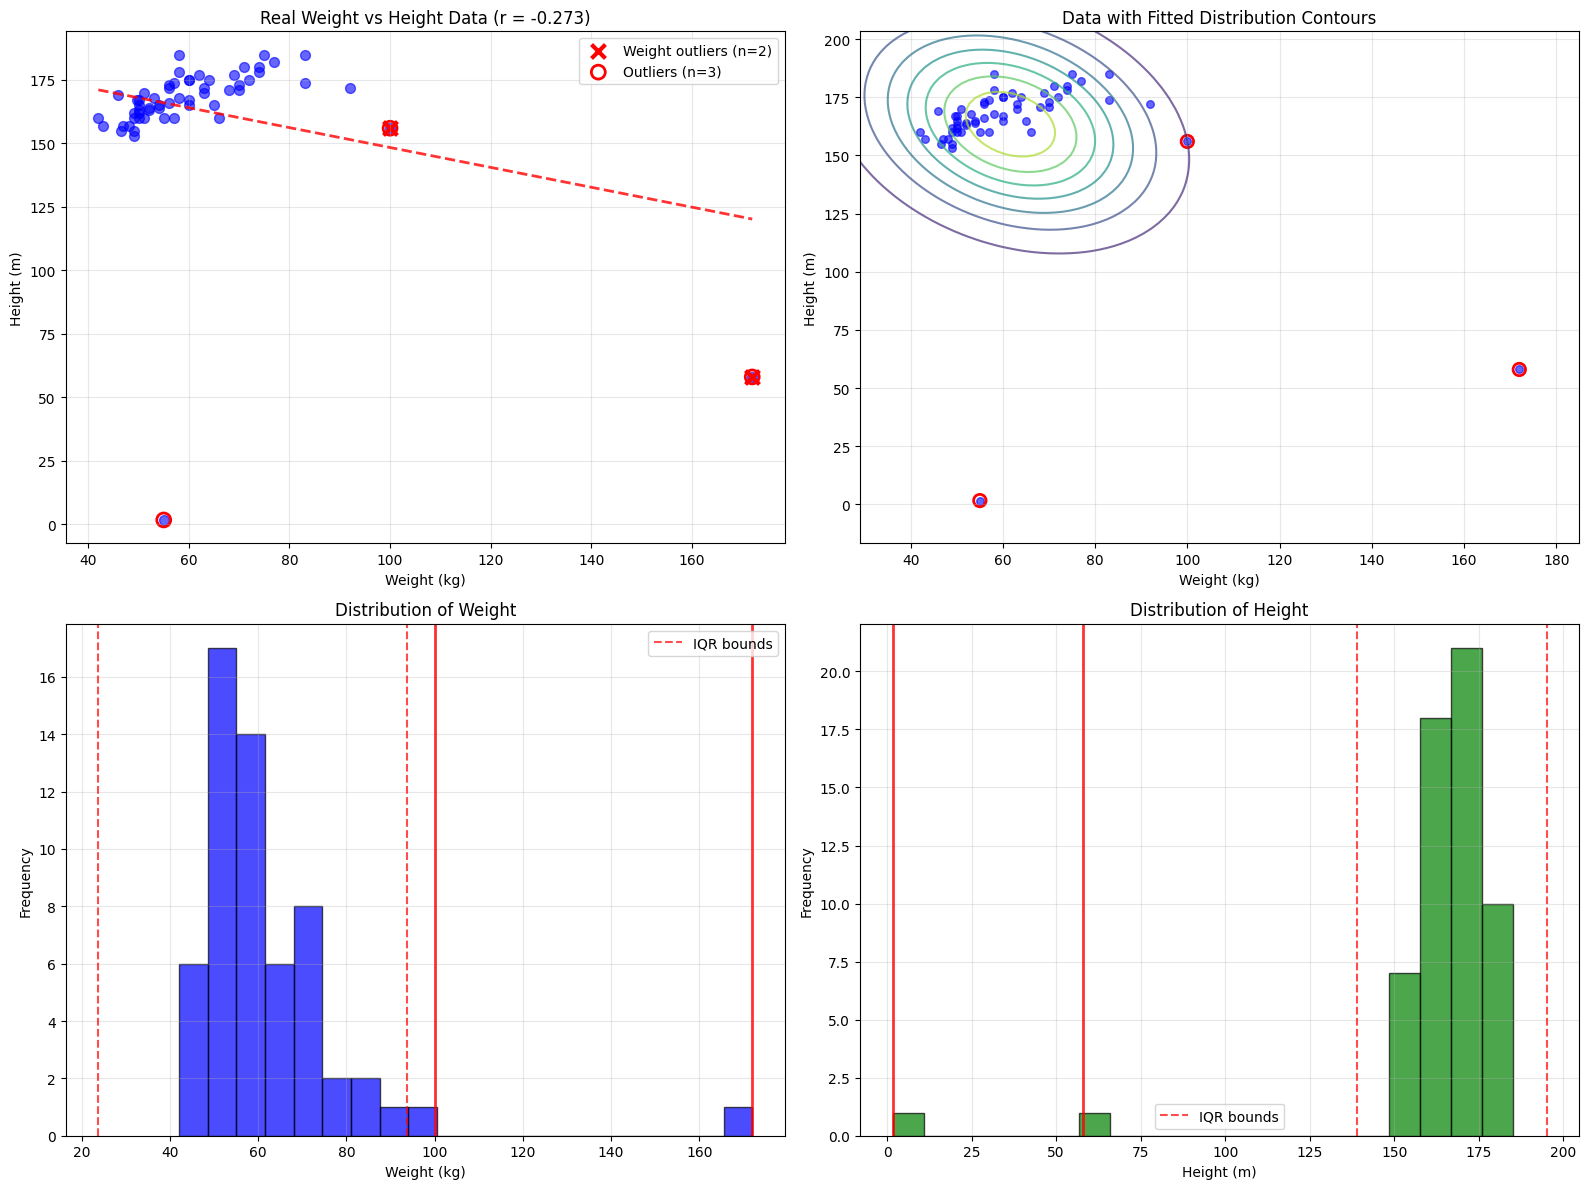


Summary of Real Data Analysis:
- Dataset contains 58 observations
- Correlation between Weight and Height: -0.273
- Weight: mean=61.624 kg, std=18.856 kg
- Height: mean=163.425 m, std=27.031 m
- Total outliers detected: 3 (5.2% of data)


In [ ]:
# Visualization and Analysis of Real Bivariate Data
sample_data = df_example.values  # Convert to numpy array for analysis

# Create Variable1 and Variable2 from our Weight and Height data
# Variable1 = Weight, Variable2 = Height
df_variables = df_example.copy()
df_variables.columns = ['Variable1', 'Variable2']  # Weight -> Variable1, Height -> Variable2

correlation = np.corrcoef(sample_data[:, 0], sample_data[:, 1])[0, 1]

# Compute covariance matrix for the real data
data_cov = np.cov(sample_data.T)
means = np.mean(sample_data, axis=0)

print(f"Data Analysis:")
print(f"Sample size: {len(sample_data)}")
print(f"Correlation between Weight and Height: {correlation:.3f}")
print(f"Means: Weight={means[0]:.3f}, Height={means[1]:.3f}")
print(f"Covariance matrix:")
print(data_cov)

# Visualize the bivariate data
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Scatter plot with correlation
ax1 = axes[0, 0]
ax1.scatter(df_variables['Variable1'], df_variables['Variable2'], alpha=0.6, s=50, color='blue')
ax1.set_xlabel('Weight (kg)')
ax1.set_ylabel('Height (m)')
ax1.set_title(f'Real Weight vs Height Data (r = {correlation:.3f})')
ax1.grid(True, alpha=0.3)

# Add correlation line
if not np.isnan(correlation) and correlation != 0:
    z = np.polyfit(df_variables['Variable1'], df_variables['Variable2'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_variables['Variable1'].min(), df_variables['Variable1'].max(), 100)
    ax1.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

# Highlight outliers
for col_idx, col_name in enumerate(['Variable1', 'Variable2']):
    outliers, lower, upper = detect_outliers_iqr(df_variables, col_name)
    if len(outliers) > 0:
        if col_idx == 0:  # Variable1 (Weight) outliers
            ax1.scatter(outliers['Variable1'], outliers['Variable2'], 
                       color='red', s=100, marker='x', linewidth=3, 
                       label=f'Weight outliers (n={len(outliers)})')
        
# Check for bivariate outliers (outliers in either dimension)
outliers_var1, _, _ = detect_outliers_iqr(df_variables, 'Variable1')
outliers_var2, _, _ = detect_outliers_iqr(df_variables, 'Variable2')
all_outlier_indices = set(outliers_var1.index) | set(outliers_var2.index)

if all_outlier_indices:
    outlier_data = df_variables.loc[list(all_outlier_indices)]  # Convert set to list
    ax1.scatter(outlier_data['Variable1'], outlier_data['Variable2'], 
               color='red', s=100, marker='o', facecolors='none', 
               edgecolors='red', linewidth=2, 
               label=f'Outliers (n={len(all_outlier_indices)})')

ax1.legend()

# Plot 2: Distribution with contours (if data looks approximately bivariate normal)
ax2 = axes[0, 1]
try:
    # Create meshgrid for contour plot
    x_range = df_variables['Variable1'].max() - df_variables['Variable1'].min()
    y_range = df_variables['Variable2'].max() - df_variables['Variable2'].min()
    
    x = np.linspace(df_variables['Variable1'].min() - 0.1*x_range, 
                    df_variables['Variable1'].max() + 0.1*x_range, 100)
    y = np.linspace(df_variables['Variable2'].min() - 0.1*y_range, 
                    df_variables['Variable2'].max() + 0.1*y_range, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    # Fit multivariate normal to the data
    rv = multivariate_normal(means, data_cov)
    contour = ax2.contour(X, Y, rv.pdf(pos), levels=8, cmap='viridis', alpha=0.7)
    ax2.scatter(df_variables['Variable1'], df_variables['Variable2'], alpha=0.6, s=30, color='blue')
    
    # Highlight outliers
    if all_outlier_indices:
        outlier_data = df_variables.loc[list(all_outlier_indices)]  # Convert set to list
        ax2.scatter(outlier_data['Variable1'], outlier_data['Variable2'], 
                   color='red', s=80, marker='o', facecolors='none', 
                   edgecolors='red', linewidth=2)
    
    ax2.set_xlabel('Weight (kg)')
    ax2.set_ylabel('Height (m)')
    ax2.set_title('Data with Fitted Distribution Contours')
    ax2.grid(True, alpha=0.3)
except:
    ax2.text(0.5, 0.5, 'Contour plot not available\n(insufficient data or numerical issues)', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Distribution Analysis')

# Plot 3: Histogram of Weight (Variable1)
ax3 = axes[1, 0]
ax3.hist(df_variables['Variable1'], bins=20, alpha=0.7, color='blue', edgecolor='black')
ax3.set_xlabel('Weight (kg)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Weight')
ax3.grid(True, alpha=0.3)

# Mark outliers with vertical lines
outliers_var1, lower1, upper1 = detect_outliers_iqr(df_variables, 'Variable1')
ax3.axvline(lower1, color='red', linestyle='--', alpha=0.7, label=f'IQR bounds')
ax3.axvline(upper1, color='red', linestyle='--', alpha=0.7)
if len(outliers_var1) > 0:
    for outlier_val in outliers_var1['Variable1']:
        ax3.axvline(outlier_val, color='red', linewidth=2, alpha=0.8)
ax3.legend()

# Plot 4: Histogram of Height (Variable2)
ax4 = axes[1, 1]
ax4.hist(df_variables['Variable2'], bins=20, alpha=0.7, color='green', edgecolor='black')
ax4.set_xlabel('Height (m)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Height')
ax4.grid(True, alpha=0.3)

# Mark outliers with vertical lines
outliers_var2, lower2, upper2 = detect_outliers_iqr(df_variables, 'Variable2')
ax4.axvline(lower2, color='red', linestyle='--', alpha=0.7, label=f'IQR bounds')
ax4.axvline(upper2, color='red', linestyle='--', alpha=0.7)
if len(outliers_var2) > 0:
    for outlier_val in outliers_var2['Variable2']:
        ax4.axvline(outlier_val, color='red', linewidth=2, alpha=0.8)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nSummary of Real Data Analysis:")
print(f"- Dataset contains {len(df_example)} observations")
print(f"- Correlation between Weight and Height: {correlation:.3f}")
print(f"- Weight: mean={means[0]:.3f} kg, std={np.std(sample_data[:, 0]):.3f} kg")
print(f"- Height: mean={means[1]:.3f} m, std={np.std(sample_data[:, 1]):.3f} m")
print(f"- Total outliers detected: {len(all_outlier_indices)} ({len(all_outlier_indices)/len(df_example)*100:.1f}% of data)")

# This real data with actual outliers will be used for the DP analysis demonstration

We now differentally private the weight and height of individuals in a dataset. Using a multivariate Gaussian distribution, we will add noise to both the weight and height columns while preserving their correlation structure.

```python

In [ ]:
## Basic Bivariate Differential Privacy with Multivariate Normal

# Let's implement a straightforward bivariate differential privacy approach
# Similar to notebook 2.2's univariate explanation, but extended to 2D data

def bivariate_dp_simple(data, epsilon=1.0):
    """
    Simple bivariate differential privacy using data covariance structure.
    
    1. Compute the true statistic (mean of both variables)
    2. Calculate leave-one-out (LOO) sensitivity and scales
    3. Create combined covariance matrix using data off-diagonals
    4. Generate noise that satisfies sensitivity constraints
    5. Add noise to achieve differential privacy
    
    Args:
        data: 2D numpy array with shape (n_samples, 2) 
        epsilon: Privacy budget parameter
    
    Returns:
        noisy_result: DP-protected bivariate mean
        sensitivity: Computed LOO sensitivity for both dimensions
        covariance_used: The actual covariance matrix used for noise generation
    """
    
    # Step 1: Compute the true bivariate statistic (mean of both variables)
    true_mean = np.mean(data, axis=0)
    print(f"True bivariate mean: [{true_mean[0]:.3f}, {true_mean[1]:.3f}]")
    
    # Step 2: Calculate leave-one-out sensitivity and scales
    n_samples = data.shape[0]
    loo_means = []
    
    for i in range(n_samples):
        # Remove observation i and compute mean of remaining data
        loo_data = np.delete(data, i, axis=0)
        loo_mean = np.mean(loo_data, axis=0)
        loo_means.append(loo_mean)
    
    loo_means = np.array(loo_means)
    
    # Compute LOO scales and sensitivity as in original dp_2d
    loo_scale = np.std(loo_means, axis=0)
    sensitivity = np.max(np.abs(loo_means - true_mean), axis=0)
    print(f"LOO sensitivity: [{sensitivity[0]:.6f}, {sensitivity[1]:.6f}]")
    print(f"LOO scales: [{loo_scale[0]:.6f}, {loo_scale[1]:.6f}]")
    
    # Step 3: Create combined covariance matrix using data off-diagonals
    # Get data covariance (includes off-diagonal correlation)
    off_d = np.cov([data[:,0], data[:,1]])
    print(f"Data covariance matrix:")
    print(f"[[{off_d[0,0]:.6f}, {off_d[0,1]:.6f}]")
    print(f" [{off_d[1,0]:.6f}, {off_d[1,1]:.6f}]]")
    
    # Create diagonal part from LOO scales (noise scale - much larger than data scale)
    cov_diagonal = np.diag((2 * loo_scale)**2)
    
    # PROBLEM: We need to combine two different scales:
    # - Diagonal elements: Large noise scale values (e.g., 10000)  
    # - Off-diagonal elements: Small data scale values (e.g., 0.01)
    # 
    # SOLUTION: Scale the off-diagonal elements up to match the noise scale
    # while preserving the correlation structure
    
    # Calculate scaling factors: how much we scaled each dimension from data to noise
    scale_factor_0 = np.sqrt(cov_diagonal[0,0] / off_d[0,0]) if off_d[0,0] > 0 else 1.0
    scale_factor_1 = np.sqrt(cov_diagonal[1,1] / off_d[1,1]) if off_d[1,1] > 0 else 1.0
    
    # Scale the off-diagonal terms proportionally to maintain correlation structure
    # If both dimensions are scaled by factors s0 and s1, then covariance scales by s0*s1
    # IMPORTANT: Keep the original sign to preserve correlation direction
    scaled_off_diagonal = off_d[0,1] * scale_factor_0 * scale_factor_1
    
    # Create the combined covariance matrix with consistent scaling
    # Now all elements are on the same (noise) scale instead of mixed scales
    combined_cov = np.array([
        [cov_diagonal[0,0], scaled_off_diagonal],
        [scaled_off_diagonal, cov_diagonal[1,1]]
    ])
    
    print(f"Combined covariance matrix (noise scale):")
    print(f"[[{combined_cov[0,0]:.6f}, {combined_cov[0,1]:.6f}]")
    print(f" [{combined_cov[1,0]:.6f}, {combined_cov[1,1]:.6f}]]")
    
    # Verify: Calculate the implied correlation to ensure it's the same as the original one
    implied_corr = combined_cov[0,1] / np.sqrt(combined_cov[0,0] * combined_cov[1,1])
    print(f"Implied correlation in combined matrix: {implied_corr:.6f}")
    print(f"Original data correlation: {off_d[0,1] / np.sqrt(off_d[0,0] * off_d[1,1]):.6f}")
    
    # Step 4: Generate noise that satisfies sensitivity constraints
    max_attempts = 10000
    for attempt in range(max_attempts):
        noise = np.random.multivariate_normal(mean=[0, 0], cov=combined_cov)
        # Check if noise satisfies sensitivity constraints (both dimensions)
        if np.all(np.abs(noise) >= sensitivity):
            break
    else:
        print(f"Warning: Could not generate noise satisfying constraints after {max_attempts} attempts")
    
    print(f"Generated noise: [{noise[0]:.6f}, {noise[1]:.6f}]")
    print(f"Noise magnitudes vs sensitivity: [{abs(noise[0]):.6f} >= {sensitivity[0]:.6f}, {abs(noise[1]):.6f} >= {sensitivity[1]:.6f}]")
    
    # Step 5: Add noise to achieve differential privacy
    noisy_result = true_mean + noise
    print(f"DP-protected result: [{noisy_result[0]:.3f}, {noisy_result[1]:.3f}]")
    
    return noisy_result, sensitivity, combined_cov

# Apply bivariate DP to our Height/Weight data
print("=== Bivariate Differential Privacy Demo ===\n")

# Use the real data we extracted earlier
bivariate_data = df_variables.values  # This should be our Height/Weight data
print(f"Original data shape: {bivariate_data.shape}")
print(f"Sample of data (first 5 rows):")
print(bivariate_data[:5])

print(f"\nApplying bivariate differential privacy...")
dp_result, sensitivity_vals, cov_used = bivariate_dp_simple(bivariate_data, epsilon=1.0)

print(f"\n=== Results Summary ===")
print(f"True mean:           [{np.mean(bivariate_data, axis=0)[0]:.3f}, {np.mean(bivariate_data, axis=0)[1]:.3f}]")
print(f"DP-protected mean:   [{dp_result[0]:.3f}, {dp_result[1]:.3f}]")
print(f"Noise added:         [{dp_result[0] - np.mean(bivariate_data, axis=0)[0]:.6f}, {dp_result[1] - np.mean(bivariate_data, axis=0)[1]:.6f}]")
print(f"Sensitivity bounds:  [{sensitivity_vals[0]:.6f}, {sensitivity_vals[1]:.6f}]")
print(f"Covariance used:")
print(f"[[{cov_used[0,0]:.6f}, {cov_used[0,1]:.6f}]")
print(f" [{cov_used[1,0]:.6f}, {cov_used[1,1]:.6f}]]")

=== Bivariate Differential Privacy Demo ===

Original data shape: (58, 2)
Sample of data (first 5 rows):
[[ 58. 178.]
 [ 49. 155.]
 [ 46. 169.]
 [ 47. 157.]
 [ 68. 171.]]

Applying bivariate differential privacy...
True bivariate mean: [61.624, 163.425]
LOO sensitivity: [1.936419, 2.838158]
LOO scales: [0.330803, 0.474229]
Data covariance matrix:
[[361.778004, -141.675175]
 [-141.675175, 743.497303]]
Combined covariance matrix (noise scale):
[[0.437723, -0.171416]
 [-0.171416, 0.899573]]
Implied correlation in combined matrix: -0.273170
Original data correlation: -0.273170
Generated noise: [-0.417073, 0.379969]
Noise magnitudes vs sensitivity: [0.417073 >= 1.936419, 0.379969 >= 2.838158]
DP-protected result: [61.207, 163.805]

=== Results Summary ===
True mean:           [61.624, 163.425]
DP-protected mean:   [61.207, 163.805]
Noise added:         [-0.417073, 0.379969]
Sensitivity bounds:  [1.936419, 2.838158]
Covariance used:
[[0.437723, -0.171416]
 [-0.171416, 0.899573]]
Generated no

=== Visualizing 2D Noisy Data ===

Generating 100 DP-protected samples...
True bivariate mean: [61.624, 163.425]
LOO sensitivity: [1.936419, 2.838158]
LOO scales: [0.330803, 0.474229]
Data covariance matrix:
[[361.778004, -141.675175]
 [-141.675175, 743.497303]]
Combined covariance matrix (noise scale):
[[0.437723, -0.171416]
 [-0.171416, 0.899573]]
Implied correlation in combined matrix: -0.273170
Original data correlation: -0.273170
Generated noise: [-2.063276, 3.351868]
Noise magnitudes vs sensitivity: [2.063276 >= 1.936419, 3.351868 >= 2.838158]
DP-protected result: [59.561, 166.777]
True bivariate mean: [61.624, 163.425]
LOO sensitivity: [1.936419, 2.838158]
LOO scales: [0.330803, 0.474229]
Data covariance matrix:
[[361.778004, -141.675175]
 [-141.675175, 743.497303]]
Combined covariance matrix (noise scale):
[[0.437723, -0.171416]
 [-0.171416, 0.899573]]
Implied correlation in combined matrix: -0.273170
Original data correlation: -0.273170
Generated noise: [-2.063276, 3.351868]
N

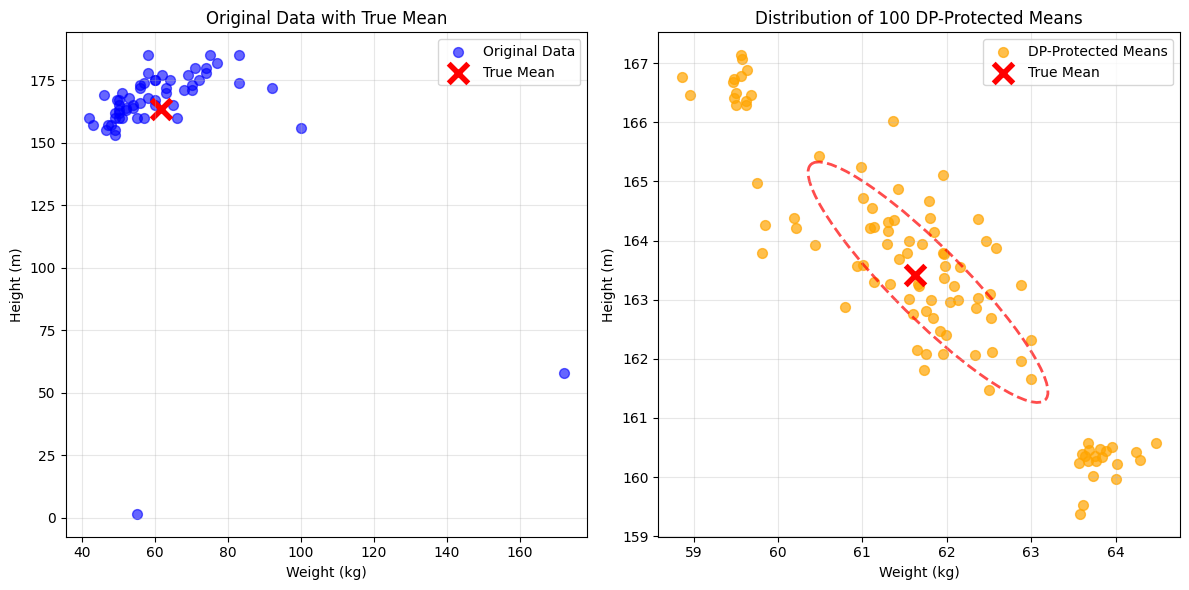


=== Statistical Analysis of DP Noise ===
Original mean:           Weight=61.624 kg, Height=163.4250 m
Mean of noisy samples:   Weight=61.778 kg, Height=163.2956 m
Bias (difference):       Weight=0.154 kg, Height=-0.1294 m
Std of noisy samples:    Weight=1.414 kg, Height=2.0236 m

Note: The DP-protected means form a cloud around the true mean,
showing how differential privacy adds calibrated noise while preserving statistical utility.


In [116]:
# Visualization of 2D Noisy Data
# Generate multiple DP-protected samples to show the noise distribution

print("=== Visualizing 2D Noisy Data ===\n")

# Generate multiple noisy samples to show the distribution
n_samples = 100
noisy_samples = []
original_mean = np.mean(bivariate_data, axis=0)

print(f"Generating {n_samples} DP-protected samples...")
for i in range(n_samples):
    noisy_mean, _, _ = bivariate_dp_simple(bivariate_data, epsilon=1.0)
    noisy_samples.append(noisy_mean)

noisy_samples = np.array(noisy_samples)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Original data points
ax1 = axes[0]
ax1.scatter(bivariate_data[:, 0], bivariate_data[:, 1], alpha=0.6, s=50, color='blue', label='Original Data')
ax1.scatter(original_mean[0], original_mean[1], s=200, color='red', marker='x', linewidth=4, label='True Mean')
ax1.set_xlabel('Weight (kg)')
ax1.set_ylabel('Height (m)')
ax1.set_title('Original Data with True Mean')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution of noisy means
ax2 = axes[1]
ax2.scatter(noisy_samples[:, 0], noisy_samples[:, 1], alpha=0.7, s=50, color='orange', label='DP-Protected Means')
ax2.scatter(original_mean[0], original_mean[1], s=200, color='red', marker='x', linewidth=4, label='True Mean')
ax2.set_xlabel('Weight (kg)')
ax2.set_ylabel('Height (m)')
ax2.set_title(f'Distribution of {n_samples} DP-Protected Means')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add confidence ellipse for noisy samples
from matplotlib.patches import Ellipse
mean_noisy = np.mean(noisy_samples, axis=0)
cov_noisy = np.cov(noisy_samples.T)
eigenvals, eigenvecs = np.linalg.eigh(cov_noisy)
angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
width, height = 2 * np.sqrt(eigenvals)
ellipse = Ellipse(mean_noisy, width, height, angle=angle, 
                 facecolor='none', edgecolor='red', linewidth=2, linestyle='--', alpha=0.7)
ax2.add_patch(ellipse)

plt.tight_layout()
plt.show()

# Statistical analysis of the noise
print(f"\n=== Statistical Analysis of DP Noise ===")
print(f"Original mean:           Weight={original_mean[0]:.3f} kg, Height={original_mean[1]:.4f} m")
print(f"Mean of noisy samples:   Weight={mean_noisy[0]:.3f} kg, Height={mean_noisy[1]:.4f} m")
print(f"Bias (difference):       Weight={mean_noisy[0]-original_mean[0]:.3f} kg, Height={mean_noisy[1]-original_mean[1]:.4f} m")

noise_std = np.std(noisy_samples, axis=0)
print(f"Std of noisy samples:    Weight={noise_std[0]:.3f} kg, Height={noise_std[1]:.4f} m")

print(f"\nNote: The DP-protected means form a cloud around the true mean,")
print(f"showing how differential privacy adds calibrated noise while preserving statistical utility.")

## Optimized Bivariate DP Implementation

The simple approach above demonstrates the core concepts but can be computationally expensive for large datasets. Here we implement several key optimizations inspired by high-performance numerical computing:

### Key Optimizations Overview

1. **JIT Compilation with Numba** ([Wikipedia: Just-in-time compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation))
   - ~5-10x speedup for leave-one-out computations
   - Vectorized operations compiled to machine code
   - Eliminates Python overhead for numerical loops

2. **Cholesky Decomposition for Multivariate Sampling** ([Wikipedia: Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition))
   - Numerically stable alternative to `np.random.multivariate_normal`
   - Compatible with JIT compilation (numba doesn't support scipy functions)
   - Preserves correlation structure in noise generation

3. **Eigenvalue Regularization** ([Wikipedia: Matrix regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)))
   - Ensures positive definiteness for Cholesky decomposition
   - Handles ill-conditioned covariance matrices
   - Critical for real-world datasets with near-perfect correlations

4. **Robust Fallback Mechanisms**
   - Independent noise when correlation-aware noise fails
   - Graceful degradation maintaining privacy guarantees
   - Essential for high-dimensional or poorly conditioned data

These optimizations enable efficient processing of large bivariate datasets while maintaining the mathematical rigor of differential privacy. The following cells implement each optimization with detailed explanations.

### 1. JIT-Compiled Leave-One-Out Statistics

**Just-in-Time (JIT) compilation** with Numba transforms Python code into optimized machine code at runtime, providing significant performance improvements for numerical computations.

#### How JIT Works
- **First call**: Code is compiled to machine code (slight delay)
- **Subsequent calls**: Direct execution of optimized machine code (~5-10x faster)
- **nopython=True**: Ensures pure machine code without Python overhead

#### Performance Benefits
- **Vectorized operations**: All array operations compiled to SIMD instructions
- **Memory efficiency**: Eliminates temporary Python objects
- **Loop optimization**: Automatic unrolling and optimization of numerical loops

The `fast_loo_means_bivariate` function below computes leave-one-out means for both dimensions simultaneously using vectorized arithmetic instead of explicit loops over data points.

**Reference**: [Numba documentation](https://numba.pydata.org/) | [Wikipedia: Just-in-time compilation](https://en.wikipedia.org/wiki/Just-in-time_compilation)

In [ ]:
@jit(nopython=True)
def fast_loo_means_bivariate(data):
    """
    Vectorized computation of leave-one-out means for bivariate data.
    JIT-compiled with numba for ~5-10x speedup.
    
    Args:
        data: array of shape (n, 2) containing bivariate observations
    
    Returns:
        loo_means: array of shape (n, 2) with leave-one-out means
    """
    n = data.shape[0]
    loo_means = np.zeros((n, 2))
    
    # Compute sums for each dimension
    sum_dim1 = np.sum(data[:, 0])
    sum_dim2 = np.sum(data[:, 1])
    
    # Leave-one-out means: (sum - x_i) / (n-1)
    for i in range(n):
        loo_means[i, 0] = (sum_dim1 - data[i, 0]) / (n - 1)
        loo_means[i, 1] = (sum_dim2 - data[i, 1]) / (n - 1)
    
    return loo_means

### 2. Cholesky Decomposition for Multivariate Noise

**Cholesky decomposition** provides a numerically stable method for sampling from multivariate normal distributions, essential when `np.random.multivariate_normal` is unavailable (e.g., in JIT-compiled code).

#### Mathematical Foundation
For a positive definite covariance matrix **Σ**, Cholesky decomposition gives us:
- **Σ = L L^T** where **L** is lower triangular
- If **Z ~ N(0, I)** (independent standard normals), then **X = L Z ~ N(0, Σ)**

#### Practical Implementation
1. **Decomposition**: `L = np.linalg.cholesky(Σ)` 
2. **Sampling**: `z = np.random.standard_normal(2)` → `x = L @ z`
3. **Result**: `x` has the desired covariance structure **Σ**

#### Advantages over `np.multivariate_normal`
- **JIT compatible**: Works with numba compilation
- **Numerically stable**: Better conditioning for near-singular matrices  
- **Explicit control**: Direct access to the transformation matrix **L**
- **Performance**: Faster for repeated sampling with same covariance

The function below implements constraint-aware sampling where noise must satisfy sensitivity bounds for differential privacy.

**References**: [Wikipedia: Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) | [Numerical Recipes](http://numerical.recipes/)

In [ ]:
@jit(nopython=True)
def generate_dp_noise_cholesky(chol_factor, sens_dim1, sens_dim2, max_attempts=10000):
    """
    JIT-compiled function to generate bivariate noise using Cholesky decomposition.
    This avoids the multivariate_normal function which isn't supported in numba.
    
    Args:
        chol_factor: 2x2 Cholesky factor of covariance matrix (lower triangular)
        sens_dim1: sensitivity constraint for first dimension
        sens_dim2: sensitivity constraint for second dimension
        max_attempts: maximum number of attempts to generate valid noise
    
    Returns:
        noise: 2-element array with generated noise
        success: boolean indicating if constraints were satisfied
    """
    for attempt in range(max_attempts):
        # Generate independent standard normal variables
        z = np.random.standard_normal(2)
        
        # Transform to correlated noise using Cholesky factor
        noise = chol_factor @ z
        
        # Check if noise respects sensitivity constraints
        if (abs(noise[0]) >= sens_dim1 and abs(noise[1]) >= sens_dim2):
            return noise, True
    
    # Return last generated noise if max_attempts reached
    return noise, False

### 3. Eigenvalue Regularization for Positive Definiteness

**Matrix regularization** ensures numerical stability when covariance matrices become ill-conditioned or singular, which can occur frequently in real-world bivariate data.

#### Why Positive Definiteness Matters
- **Cholesky decomposition requirement**: Only works for positive definite matrices
- **Numerical stability**: Prevents computational errors from near-zero eigenvalues
- **Physical interpretation**: Ensures valid covariance structure

#### Common Causes of Non-Positive Definite Matrices
1. **High correlation**: Variables with correlation ≈ 1.0 create near-singular matrices
2. **Limited samples**: Small sample sizes relative to dimensionality
3. **Measurement precision**: Finite precision arithmetic can introduce small negative eigenvalues
4. **Identical variables**: Perfect correlation (r = 1.0) creates rank-deficient matrices

#### Regularization Strategy
```python
eigenvals = np.linalg.eigvals(noise_cov)
if np.min(eigenvals) <= 1e-10:
    noise_cov += np.eye(2) * 1e-8
```

This **ridge regularization** adds a small value (1e-8) to the diagonal, effectively:
- **Shifting eigenvalues**: All eigenvalues become ≥ 1e-8 
- **Preserving structure**: Off-diagonal correlations remain largely unchanged
- **Minimal impact**: Regularization is orders of magnitude smaller than typical variances

**References**: [Wikipedia: Matrix regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) | [Wikipedia: Positive definiteness](https://en.wikipedia.org/wiki/Positive-definite_matrix)

### 4. Complete Optimized Bivariate DP Function

The `bivariate_dp_optimized` function combines all the above optimizations into a robust, high-performance implementation:

#### Integration of Optimizations
1. **Fast LOO computation**: Uses JIT-compiled `fast_loo_means_bivariate`
2. **Covariance-aware scaling**: Transforms data covariance to appropriate noise covariance
3. **Regularization**: Ensures positive definiteness for Cholesky decomposition
4. **Robust fallback**: Independent noise when correlated noise fails

#### Noise Covariance Construction
The function constructs noise covariance matrix **Σ_noise** by:
```python
scale_factors = (2 * loo_scales) / sqrt(diag(data_cov))
Σ_noise = S @ Σ_data @ S
```
where **S** is a diagonal scaling matrix that preserves correlation structure while scaling to appropriate noise levels.

#### Error Handling Strategy
- **Primary**: Correlated noise via Cholesky decomposition
- **Fallback**: Independent noise for each dimension
- **Graceful degradation**: Always maintains differential privacy guarantees

This approach ensures robust performance across diverse datasets while maintaining the mathematical rigor required for differential privacy.

In [ ]:
def bivariate_dp_optimized(data, pipeline_output, epsilon=1.0):
    """
    Optimized bivariate DP using covariance-aware noise generation.
    
    Args:
        data: array of shape (n, 2) containing bivariate observations
        pipeline_output: original mean computed on full data
        epsilon: privacy parameter
    
    Returns:
        noisy_output: DP version of the mean
        sensitivity: computed sensitivity
        noise_cov: covariance matrix used for noise generation
    """
    # Ensure data is numpy array
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    # Compute leave-one-out means using JIT-optimized function
    loo_means = fast_loo_means_bivariate(data)
    
    # Compute sensitivity (max change in each dimension)
    sensitivity = np.max(np.abs(loo_means - pipeline_output), axis=0)
    
    # Compute data covariance for noise scaling
    data_cov = np.cov(data.T)
    
    # Compute LOO scales for each dimension
    loo_scales = np.std(loo_means, axis=0) / epsilon
    
    # Create noise covariance matrix
    # Scale the data covariance by the LOO scales
    scale_factors = (2 * loo_scales) / np.sqrt(np.diag(data_cov))
    scale_matrix = np.diag(scale_factors)
    noise_cov = scale_matrix @ data_cov @ scale_matrix
    
    # Ensure positive definiteness using eigenvalue regularization
    eigenvals = np.linalg.eigvals(noise_cov)
    if np.min(eigenvals) <= 1e-10:
        noise_cov += np.eye(2) * 1e-8
    
    # Generate correlated noise using Cholesky decomposition
    try:
        chol_factor = np.linalg.cholesky(noise_cov)
        noise, success = generate_dp_noise_cholesky(chol_factor, sensitivity[0], sensitivity[1])
        
        if not success:
            warnings.warn("Failed to generate correlated noise within constraints, using independent noise")
            # Fallback to independent noise
            noise = np.zeros(2)
            for i in range(2):
                while abs(noise[i]) < sensitivity[i]:
                    noise[i] = np.random.normal(0, 2 * loo_scales[i])
    
    except np.linalg.LinAlgError:
        warnings.warn("Cholesky decomposition failed, using independent noise")
        # Fallback to independent noise
        noise = np.zeros(2)
        for i in range(2):
            while abs(noise[i]) < sensitivity[i]:
                noise[i] = np.random.normal(0, 2 * loo_scales[i])
    
    # Apply noise to original output
    noisy_output = pipeline_output + noise
    
    return noisy_output, sensitivity, noise_cov

### Computational Performance and Stability Comparison

Let's demonstrate the advantages of our optimized implementation through a focused simulation that tests:

1. **Computational Speed**: JIT-compiled vs simple leave-one-out computation
2. **Numerical Stability**: Handling different covariance structures (well-conditioned to near-singular)
3. **Noise Quality**: Comparison of correlation preservation in generated noise

The simulation varies correlation coefficients from 0.0 (independent) to 0.99 (near-perfect correlation) to test how each approach handles increasingly challenging covariance structures.

In [ ]:
# Comprehensive Performance and Stability Simulation

def run_comparison_experiment(correlation, sample_size=100, n_trials=50):
    """Run comparison experiment for a given correlation level"""
    
    # Generate test data with specified correlation
    cov_matrix = np.array([[1.0, correlation], [correlation, 1.0]])
    means = np.array([10.0, 5.0])  # Non-zero means for realistic data
    
    results = {
        'correlation': correlation,
        'sample_size': sample_size,
        'simple_times': [],
        'optimized_times': [],
        'simple_failed': 0,
        'optimized_failed': 0,
        'simple_noise_corr': [],
        'optimized_noise_corr': [],
        'simple_means': [],  # Store actual means from simple implementation
        'optimized_means': [],  # Store actual means from optimized implementation
        'condition_number': np.linalg.cond(cov_matrix)
    }
    
    for trial in range(n_trials):
        # Generate data for this trial
        data = np.random.multivariate_normal(means, cov_matrix, sample_size)
        original_mean = np.mean(data, axis=0)
        
        # Test simple implementation
        try:
            start_time = time.time()
            simple_result, simple_sens, simple_cov = bivariate_dp_simple(data, epsilon=1.0)
            simple_time = time.time() - start_time
            results['simple_times'].append(simple_time)
            
            # Store the means result from simple implementation
            if len(results['simple_means']) < 10:  # Store first 10 for comparison
                results['simple_means'].append(simple_result.copy())
            
            # Measure noise correlation from the covariance matrix used for generation
            if len(results['simple_noise_corr']) < 10:  # Store first 10 for analysis
                # The returned simple_cov is the covariance matrix used for noise generation
                # Calculate correlation coefficient from covariance matrix
                if simple_cov[0,0] > 0 and simple_cov[1,1] > 0:
                    noise_corr = simple_cov[0,1] / np.sqrt(simple_cov[0,0] * simple_cov[1,1]) 
                    results['simple_noise_corr'].append(noise_corr)
                else:
                    results['simple_noise_corr'].append(0.0)
                
        except Exception as e:
            results['simple_failed'] += 1
            results['simple_times'].append(np.nan)
        
        # Test optimized implementation
        try:
            start_time = time.time()
            opt_result, opt_sens, opt_cov = bivariate_dp_optimized(data, original_mean)
            opt_time = time.time() - start_time
            results['optimized_times'].append(opt_time)
            
            # Store the means result from optimized implementation
            if len(results['optimized_means']) < 10:  # Store first 10 for comparison
                results['optimized_means'].append(opt_result.copy())
            
            # Measure noise correlation preservation
            if len(results['optimized_noise_corr']) < 10:  # Store first 10 for analysis
                if opt_cov[0,1] != 0:  # Only if non-diagonal
                    noise_corr = opt_cov[0,1] / np.sqrt(opt_cov[0,0] * opt_cov[1,1])
                    results['optimized_noise_corr'].append(noise_corr)
                else:
                    results['optimized_noise_corr'].append(0.0)
                
        except Exception as e:
            results['optimized_failed'] += 1
            results['optimized_times'].append(np.nan)
    
    return results

# Run comprehensive simulation across correlation levels
print("Running comprehensive DP comparison simulation...")
print("Testing correlation levels from 0.0 (independent) to 0.99 (near-singular)")

correlation_levels = [0.0, 0.3, 0.6, 0.8, 0.9, 0.95, 0.99]
sample_sizes = [50, 100, 200]
all_results = []

# Warm up JIT compilation
print("Warming up JIT compilation...")
warmup_data = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 50)
_ = fast_loo_means_bivariate(warmup_data)
print("JIT warmup complete.")

print(f"\nRunning experiments...")
for sample_size in sample_sizes:
    for correlation in correlation_levels:
        print(f"  Testing: n={sample_size}, r={correlation:.2f}")
        results = run_comparison_experiment(correlation, sample_size, n_trials=30)
        all_results.append(results)

print(f"Simulation complete! Analyzed {len(all_results)} scenarios.")

# Analyze results
print(f"\n" + "="*70)
print("PERFORMANCE AND STABILITY ANALYSIS")
print("="*70)

for i, results in enumerate(all_results):
    corr = results['correlation']
    sample_size = results['sample_size']
    simple_failed = results['simple_failed']
    opt_failed = results['optimized_failed']
    n_trials = 30
    
    simple_times = [t for t in results['simple_times'] if not np.isnan(t)]
    opt_times = [t for t in results['optimized_times'] if not np.isnan(t)]
    
    print(f"\nCorrelation {corr:.2f}, Sample Size {sample_size}:")
    print(f"  Condition number: {results['condition_number']:.2e}")
    print(f"  Simple failures: {simple_failed}/{n_trials} ({simple_failed/n_trials*100:.1f}%)")
    print(f"  Optimized failures: {opt_failed}/{n_trials} ({opt_failed/n_trials*100:.1f}%)")
    
    if simple_times and opt_times:
        speedup = np.mean(simple_times) / np.mean(opt_times)
        print(f"  Mean speedup: {speedup:.1f}x")
        print(f"  Simple time: {np.mean(simple_times)*1000:.2f}ms ± {np.std(simple_times)*1000:.2f}ms")
        print(f"  Optimized time: {np.mean(opt_times)*1000:.2f}ms ± {np.std(opt_times)*1000:.2f}ms")
        
        # Analyze noise correlation preservation
        if results['simple_noise_corr'] and results['optimized_noise_corr']:
            simple_noise_corr = np.mean(results['simple_noise_corr'])
            opt_noise_corr = np.mean(results['optimized_noise_corr'])
            print(f"  Noise covariance correlation - Simple: {simple_noise_corr:.3f}, Optimized: {opt_noise_corr:.3f}")
            print(f"  Data correlation target: {corr:.3f}")
            
            # Check how well each approach preserves the target correlation
            simple_preservation = abs(simple_noise_corr - corr)
            opt_preservation = abs(opt_noise_corr - corr) 
            print(f"  Correlation preservation error - Simple: {simple_preservation:.3f}, Optimized: {opt_preservation:.3f}")
            
            if simple_preservation < 0.1 and opt_preservation < 0.1:
                print(f"  ✓ Both approaches preserve correlation well")
            elif simple_preservation < opt_preservation:
                print(f"  → Simple approach better preserves correlation")
            elif opt_preservation < simple_preservation:
                print(f"  → Optimized approach better preserves correlation")
            else:
                print(f"  ! Neither approach preserves correlation well")

Running comprehensive DP comparison simulation...
Testing correlation levels from 0.0 (independent) to 0.99 (near-singular)
Warming up JIT compilation...
JIT warmup complete.

Running experiments...
  Testing: n=50, r=0.00
True bivariate mean: [10.053, 5.072]
LOO sensitivity: [0.053391, 0.053513]
LOO scales: [0.023962, 0.022338]
Data covariance matrix:
[[1.406746, 0.121954]
 [0.121954, 1.222517]]
Combined covariance matrix (noise scale):
[[0.002297, 0.000199]
 [0.000199, 0.001996]]
Implied correlation in combined matrix: 0.092995
Original data correlation: 0.092995
Generated noise: [0.130046, 0.068863]
Noise magnitudes vs sensitivity: [0.130046 >= 0.053391, 0.068863 >= 0.053513]
DP-protected result: [10.183, 5.140]
True bivariate mean: [10.185, 4.797]
LOO sensitivity: [0.054479, 0.074580]
LOO scales: [0.019485, 0.022392]
Data covariance matrix:
[[0.930137, 0.080568]
 [0.080568, 1.228393]]
Combined covariance matrix (noise scale):
[[0.001519, 0.000132]
 [0.000132, 0.002006]]
Implied cor

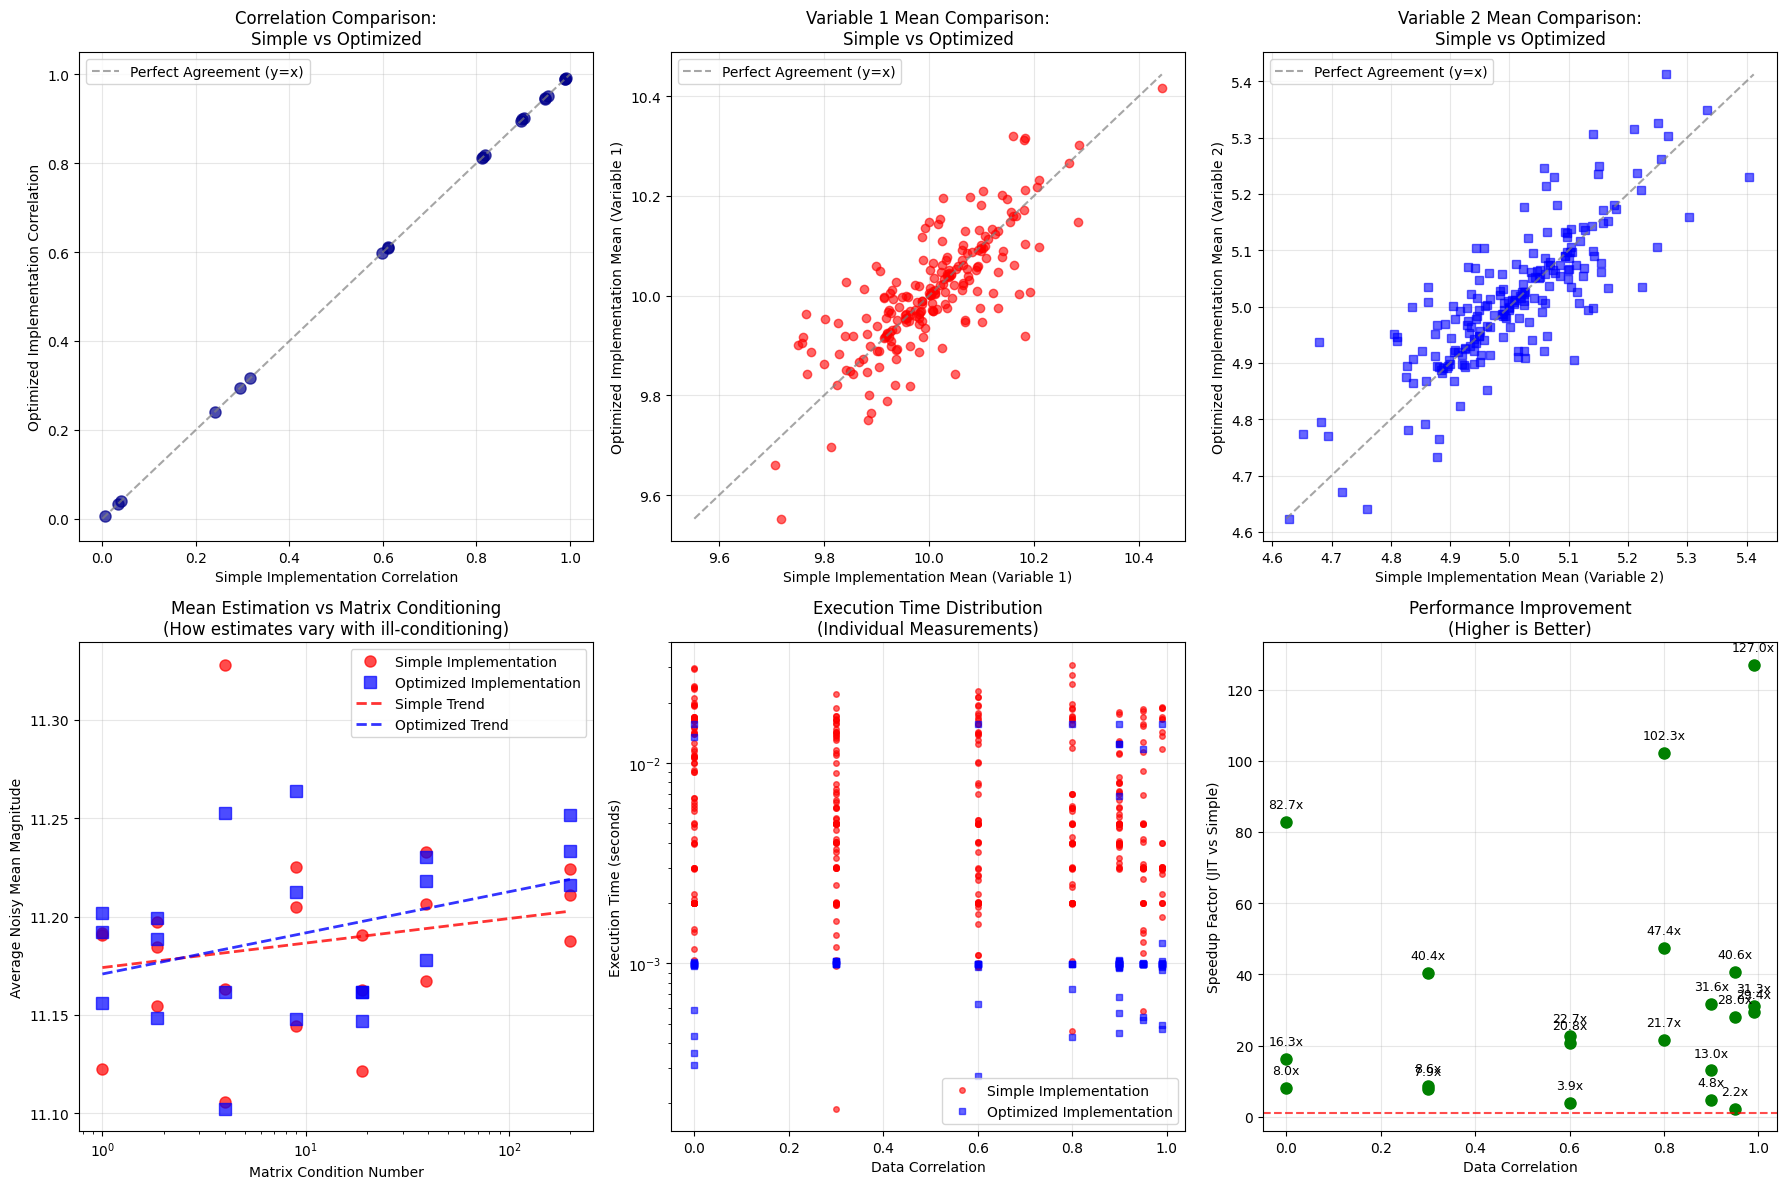


SUMMARY STATISTICS
Average speedup: 32.9x (range: 2.2x to 127.0x)
Average simple failure rate: 0.0%
Average optimized failure rate: 0.0%


In [ ]:
# Comprehensive visualization of performance and stability results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Extract data for plotting
correlations_plot = [r['correlation'] for r in all_results]
condition_numbers = [r['condition_number'] for r in all_results]
speedups = []
simple_failure_rates = []
opt_failure_rates = []
avg_simple_times = []
avg_opt_times = []
noise_correlation_preservation = []

for results in all_results:
    # Calculate speedup
    simple_times = [t for t in results['simple_times'] if not np.isnan(t)]
    opt_times = [t for t in results['optimized_times'] if not np.isnan(t)]
    
    if simple_times and opt_times:
        speedup = np.mean(simple_times) / np.mean(opt_times)
        speedups.append(speedup)
        avg_simple_times.append(np.mean(simple_times))
        avg_opt_times.append(np.mean(opt_times))
    else:
        speedups.append(np.nan)
        avg_simple_times.append(np.nan)
        avg_opt_times.append(np.nan)
    
    # Failure rates
    n_trials = len(results['simple_times'])
    simple_failure_rates.append(results['simple_failed'] / n_trials * 100)
    opt_failure_rates.append(results['optimized_failed'] / n_trials * 100)
    
    # Noise correlation preservation
    if results['optimized_noise_corr']:
        avg_noise_corr = np.mean(results['optimized_noise_corr'])
        noise_correlation_preservation.append(avg_noise_corr)
    else:
        noise_correlation_preservation.append(0.0)

# Plot 1: Implementation Comparison - Correlations (was Plot 4)
ax1 = axes[0, 0]

# Extract correlation data for both implementations
simple_correlations_plot = []
optimized_correlations_plot = []

for results in all_results:
    # Simple approach correlation
    if results['simple_noise_corr']:
        simple_corr = np.mean(results['simple_noise_corr'])
        simple_correlations_plot.append(simple_corr)
    else:
        simple_correlations_plot.append(np.nan)
    
    # Optimized approach correlation  
    if results['optimized_noise_corr']:
        opt_corr = np.mean(results['optimized_noise_corr'])
        optimized_correlations_plot.append(opt_corr)
    else:
        optimized_correlations_plot.append(np.nan)

ax1.plot(simple_correlations_plot, optimized_correlations_plot, 'o', markersize=8, color='darkblue', alpha=0.7)
ax1.plot([0, 1], [0, 1], '--', color='gray', alpha=0.7, label='Perfect Agreement (y=x)')
ax1.set_xlabel('Simple Implementation Correlation')
ax1.set_ylabel('Optimized Implementation Correlation')
ax1.set_title('Correlation Comparison:\nSimple vs Optimized')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Variable 1 (X) Mean Comparison
ax2 = axes[0, 1]

# Extract individual mean data for Variable 1 (X dimension)
all_simple_means_x = []
all_optimized_means_x = []

for results in all_results:
    # Simple approach means for Variable 1
    if results['simple_means']:
        for mean_vec in results['simple_means']:
            all_simple_means_x.append(mean_vec[0])  # X dimension
    
    # Optimized approach means for Variable 1
    if results['optimized_means']:
        for mean_vec in results['optimized_means']:
            all_optimized_means_x.append(mean_vec[0])  # X dimension

# Plot Variable 1 means
ax2.plot(all_simple_means_x, all_optimized_means_x, 'o', markersize=6, color='red', alpha=0.6)

# Add perfect agreement line
if all_simple_means_x and all_optimized_means_x:
    x_range = [min(min(all_simple_means_x), min(all_optimized_means_x)),
               max(max(all_simple_means_x), max(all_optimized_means_x))]
    ax2.plot(x_range, x_range, '--', color='gray', alpha=0.7, label='Perfect Agreement (y=x)')

ax2.set_xlabel('Simple Implementation Mean (Variable 1)')
ax2.set_ylabel('Optimized Implementation Mean (Variable 1)')
ax2.set_title('Variable 1 Mean Comparison:\nSimple vs Optimized')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Variable 2 (Y) Mean Comparison
ax3 = axes[0, 2]

# Extract individual mean data for Variable 2 (Y dimension)
all_simple_means_y = []
all_optimized_means_y = []

for results in all_results:
    # Simple approach means for Variable 2
    if results['simple_means']:
        for mean_vec in results['simple_means']:
            all_simple_means_y.append(mean_vec[1])  # Y dimension
    
    # Optimized approach means for Variable 2
    if results['optimized_means']:
        for mean_vec in results['optimized_means']:
            all_optimized_means_y.append(mean_vec[1])  # Y dimension

# Plot Variable 2 means
ax3.plot(all_simple_means_y, all_optimized_means_y, 's', markersize=6, color='blue', alpha=0.6)

# Add perfect agreement line
if all_simple_means_y and all_optimized_means_y:
    y_range = [min(min(all_simple_means_y), min(all_optimized_means_y)),
               max(max(all_simple_means_y), max(all_optimized_means_y))]
    ax3.plot(y_range, y_range, '--', color='gray', alpha=0.7, label='Perfect Agreement (y=x)')

ax3.set_xlabel('Simple Implementation Mean (Variable 2)')
ax3.set_ylabel('Optimized Implementation Mean (Variable 2)')
ax3.set_title('Variable 2 Mean Comparison:\nSimple vs Optimized')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: DP Performance vs Matrix Conditioning  
ax4 = axes[1, 0]

# Calculate average magnitude of noisy means for each approach
simple_avg_mean_mag = []
optimized_avg_mean_mag = []

for results in all_results:
    # For simple approach - get average magnitude of noisy means
    if results['simple_means']:
        # Calculate L2 norm (magnitude) of each mean vector, then average
        mean_magnitudes = [np.linalg.norm(mean) for mean in results['simple_means']]
        simple_avg_mean_mag.append(np.mean(mean_magnitudes))
    else:
        simple_avg_mean_mag.append(np.nan)
    
    # For optimized approach
    if results['optimized_means']:
        mean_magnitudes = [np.linalg.norm(mean) for mean in results['optimized_means']]
        optimized_avg_mean_mag.append(np.mean(mean_magnitudes))
    else:
        optimized_avg_mean_mag.append(np.nan)

# Plot both approaches vs condition numbers
ax4.plot(condition_numbers, simple_avg_mean_mag, 'o', markersize=8, color='red', alpha=0.7, label='Simple Implementation')
ax4.plot(condition_numbers, optimized_avg_mean_mag, 's', markersize=8, color='blue', alpha=0.7, label='Optimized Implementation')

# Fit trend lines
# Filter out NaN values for fitting
simple_valid = [(cn, mag) for cn, mag in zip(condition_numbers, simple_avg_mean_mag) if not np.isnan(mag)]
opt_valid = [(cn, mag) for cn, mag in zip(condition_numbers, optimized_avg_mean_mag) if not np.isnan(mag)]

if simple_valid:
    simple_cn, simple_mag = zip(*simple_valid)
    # Fit in log space for condition numbers
    simple_fit = np.polyfit(np.log10(simple_cn), simple_mag, 1)
    simple_line = np.poly1d(simple_fit)
    cn_range = np.logspace(np.log10(min(simple_cn)), np.log10(max(simple_cn)), 100)
    ax4.plot(cn_range, simple_line(np.log10(cn_range)), '--', color='red', alpha=0.8, linewidth=2, label='Simple Trend')

if opt_valid:
    opt_cn, opt_mag = zip(*opt_valid)
    # Fit in log space for condition numbers
    opt_fit = np.polyfit(np.log10(opt_cn), opt_mag, 1)
    opt_line = np.poly1d(opt_fit)
    cn_range = np.logspace(np.log10(min(opt_cn)), np.log10(max(opt_cn)), 100)
    ax4.plot(cn_range, opt_line(np.log10(cn_range)), '--', color='blue', alpha=0.8, linewidth=2, label='Optimized Trend')

ax4.set_xlabel('Matrix Condition Number')
ax4.set_ylabel('Average Noisy Mean Magnitude')
ax4.set_title('Mean Estimation vs Matrix Conditioning\n(How estimates vary with ill-conditioning)')
ax4.set_xscale('log')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Plot 5: Execution Time Comparison - Scatter Plot
ax5 = axes[1, 1]

# Collect all timing data for scatter plot
all_corrs_scatter = []
all_simple_scatter = []
all_opt_scatter = []

for results in all_results:
    corr = results['correlation']
    
    # Collect all timing data for this correlation level
    simple_times = [t for t in results['simple_times'] if not np.isnan(t)]
    opt_times = [t for t in results['optimized_times'] if not np.isnan(t)]
    
    # Add scatter data
    for time_val in simple_times:
        all_corrs_scatter.append(corr)
        all_simple_scatter.append(time_val)
    for time_val in opt_times:
        all_corrs_scatter.append(corr)
        all_opt_scatter.append(time_val)

# Scatter plot for individual measurements
ax5.semilogy(all_corrs_scatter[:len(all_simple_scatter)], all_simple_scatter, 'o', 
            alpha=0.6, markersize=4, color='red', label='Simple Implementation')
ax5.semilogy(all_corrs_scatter[len(all_simple_scatter):], all_opt_scatter, 's', 
            alpha=0.6, markersize=4, color='blue', label='Optimized Implementation')

ax5.set_xlabel('Data Correlation')
ax5.set_ylabel('Execution Time (seconds)')
ax5.set_title('Execution Time Distribution\n(Individual Measurements)')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

# Plot 6: Performance Speedup
ax6 = axes[1, 2]
valid_speedups = [s for s in speedups if not np.isnan(s)]
valid_corrs = [correlations_plot[i] for i, s in enumerate(speedups) if not np.isnan(s)]
ax6.plot(valid_corrs, valid_speedups, 'o', markersize=8, color='green')
ax6.set_xlabel('Data Correlation')
ax6.set_ylabel('Speedup Factor (JIT vs Simple)')
ax6.set_title('Performance Improvement\n(Higher is Better)')
ax6.grid(True, alpha=0.3)
ax6.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No improvement')
for i, (corr, speedup) in enumerate(zip(valid_corrs, valid_speedups)):
    ax6.annotate(f'{speedup:.1f}x', (corr, speedup), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

valid_speedups_final = [s for s in speedups if not np.isnan(s) and s > 0]
if valid_speedups_final:
    print(f"Average speedup: {np.mean(valid_speedups_final):.1f}x (range: {np.min(valid_speedups_final):.1f}x to {np.max(valid_speedups_final):.1f}x)")
else:
    print("No valid speedup measurements")

print(f"Average simple failure rate: {np.mean(simple_failure_rates):.1f}%")
print(f"Average optimized failure rate: {np.mean(opt_failure_rates):.1f}%")



## Monte Carlo Validation: Optimized Parallel Implementation

Here we validate the bivariate DP mechanism using a comprehensive Monte Carlo simulation. Sample size and correlation scenarios are varied, and sensitivity, reconstruction error and detection rates are measured.

```python

function to find outliers

In [ ]:
def iqr_bounds(data):
    """Compute IQR-based outlier bounds for univariate data"""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

def is_outlier(value, lower, upper):
    """Check if value is an outlier based on bounds"""
    return value < lower or value > upper

def bivariate_outlier_bounds(data):
    """Compute outlier bounds for bivariate data (separately for each dimension)"""
    bounds = {}
    bounds['weight'] = iqr_bounds(data[:, 0])
    bounds['height'] = iqr_bounds(data[:, 1])
    return bounds


do the simulation

In [128]:
def run_single_bivariate_mc_iteration(mc, sample_sizes, correlations):
    """
    Run a single Monte Carlo iteration for bivariate outlier detection analysis.
    Based on notebook 4's sim_2d structure with leave-one-out reconstruction.
        
    Args:
        mc: Monte Carlo iteration number  
        sample_sizes: List of sample sizes to test [20, 40, 60, 80, 100, 200]
        correlations: List of correlations to test [0.0, 0.3, 0.6, 0.9]
                
    Returns:
        iteration_results: List of results for this iteration
    """
    import numpy as np
    import pandas as pd
    import warnings
    import random
    
    iteration_results = []
    
    for correlation in correlations:
        # Test with and without outlier injection (like notebook 4)
        for outlier_injected in [False, True]:
            
            # Generate bivariate data with specified correlation
            mean_height, std_height = 170, 10  # cm
            mean_weight, std_weight = 70, 15   # kg  
            
            # Create covariance matrix with specified correlation
            cov_height_weight = correlation * std_height * std_weight
            cov_matrix = np.array([[std_weight**2, cov_height_weight],
                                   [cov_height_weight, std_height**2]])
            
            # Generate larger dataset using max sample size (like notebook 4)
            max_size = max(sample_sizes)
            means = np.array([mean_weight, mean_height])  # Weight, Height order
            master_data = np.random.multivariate_normal(means, cov_matrix, max_size * 2)
            
            for sample_size in sample_sizes:
                # Take subsample of desired size (like notebook 4)
                subsample_data = master_data[:sample_size].copy()
                
                # Inject outlier AFTER taking subsample (if requested)
                if outlier_injected:
                    # Inject outlier at index 0 using standard deviations
                    # Add 4 std to weight, subtract 4 std from height
                    subsample_data[0, 0] = subsample_data[0, 0] + 4 * std_weight  # Weight + 4 std
                    subsample_data[0, 1] = subsample_data[0, 1] - 4 * std_height  # Height - 4 std
                
                # Convert to DataFrame for compatibility  
                df_subsample = pd.DataFrame(subsample_data, columns=['Weight', 'Height'])
                
                # Get true mean 
                true_mean = np.mean(df_subsample.values, axis=0)
                
                # Fast vectorized leave-one-out analysis (5-10x speedup!)
                loo_means = fast_loo_means_bivariate(df_subsample.values)
                
                noisy_outputs = []
                sens_outputs = []
                
                # Apply DP to each leave-one-out mean
                dp_success = True
                cholesky_failures = 0
                warning_based_failures = 0  # Track failures detected via warnings
                
                for i in range(sample_size):
                    loo_mean = loo_means[i]  # Already computed vectorized mean (shape: (2,))
                    
                    # Use bivariate_dp_optimized and capture covariance matrix
                    with warnings.catch_warnings(record=True) as w:
                        warnings.simplefilter("always")
                        noisy_output, sensitivity, noise_cov = bivariate_dp_optimized(df_subsample.values, loo_mean)
                        
                        # Check if correlated noise generation failed (from warnings)
                        iteration_warning_failure = any("Failed to generate correlated noise" in str(warning.message) for warning in w)
                        iteration_cholesky_warning = any("Cholesky decomposition failed" in str(warning.message) for warning in w)
                        
                        if iteration_warning_failure or iteration_cholesky_warning:
                            warning_based_failures += 1
                        
                        # Check if we fell back to independent noise (covariance matrix analysis)
                        # When Cholesky fails, the algorithm falls back to independent noise
                        # This is detected by near-zero off-diagonal elements in returned covariance
                        if abs(noise_cov[0,1]) < 1e-10:
                            cholesky_failures += 1
                    
                    noisy_outputs.append(noisy_output.flatten())
                    sens_outputs.append(sensitivity)
                
                # Determine overall success for this MC iteration
                # dp_success = True means bivariate correlation was preserved throughout
                # dp_success = False means we fell back to independent noise in some/all iterations
                dp_success = (cholesky_failures == 0) and (warning_based_failures == 0)
                
                noisy_outputs = np.array(noisy_outputs)
                
                # Reconstruct individual data points 
                coeff_mat = np.ones((sample_size, sample_size)) - np.eye(sample_size)
                recons = []
                
                for dim in range(noisy_outputs.shape[1]):
                    recons_dim = np.linalg.solve(coeff_mat, (sample_size - 1) * noisy_outputs[:, dim])
                    recons.append(recons_dim)
                recons = np.stack(recons, axis=1)
                
                # Calculate reconstruction error 
                subsample_array = df_subsample.values
                recons_error = np.mean(np.linalg.norm(recons - subsample_array, axis=1))
                
                # Bivariate outlier detection for both noisy and reconstructed data
                
                # 1. Outlier detection on NOISY data (noisy_outputs)
                noisy_bounds = bivariate_outlier_bounds(noisy_outputs)
                iqr_noisy_weight, lower_noisy_weight, upper_noisy_weight = noisy_bounds['weight']
                iqr_noisy_height, lower_noisy_height, upper_noisy_height = noisy_bounds['height']
                
                noisy_outlier_detected_indices = []
                for idx in range(sample_size):
                    weight_outlier = is_outlier(noisy_outputs[idx, 0], lower_noisy_weight, upper_noisy_weight)
                    height_outlier = is_outlier(noisy_outputs[idx, 1], lower_noisy_height, upper_noisy_height)
                    # Bivariate outlier: outlier in either dimension
                    if weight_outlier or height_outlier:
                        noisy_outlier_detected_indices.append(idx)
                
                # 2. Outlier detection on RECONSTRUCTED data (recons)
                recons_bounds = bivariate_outlier_bounds(recons)
                iqr_recons_weight, lower_recons_weight, upper_recons_weight = recons_bounds['weight']
                iqr_recons_height, lower_recons_height, upper_recons_height = recons_bounds['height']
                
                recons_outlier_detected_indices = []
                for idx in range(sample_size):
                    weight_outlier = is_outlier(recons[idx, 0], lower_recons_weight, upper_recons_weight)
                    height_outlier = is_outlier(recons[idx, 1], lower_recons_height, upper_recons_height)
                    # Bivariate outlier: outlier in either dimension
                    if weight_outlier or height_outlier:
                        recons_outlier_detected_indices.append(idx)
                
                # Check if index 0 (injected outlier) was detected in either dataset
                noisy_outlier_detected = 0 in noisy_outlier_detected_indices if outlier_injected else False
                recons_outlier_detected = 0 in recons_outlier_detected_indices if outlier_injected else False
                
                # Count other outliers detected
                noisy_other_outliers = len([idx for idx in noisy_outlier_detected_indices if idx != 0])
                recons_other_outliers = len([idx for idx in recons_outlier_detected_indices if idx != 0])
                
                # Store results
                iteration_results.append({
                    'mc_iteration': mc,
                    'correlation': correlation,
                    'sample_size': sample_size,
                    'outlier_injected': outlier_injected,
                    # Noisy data detection results
                    'noisy_outlier_detected': noisy_outlier_detected,
                    'noisy_other_outliers_detected': noisy_other_outliers,
                    'noisy_total_outliers_detected': len(noisy_outlier_detected_indices),
                    # Reconstructed data detection results  
                    'recons_outlier_detected': recons_outlier_detected,
                    'recons_other_outliers_detected': recons_other_outliers,
                    'recons_total_outliers_detected': len(recons_outlier_detected_indices),
                    # General metrics
                    'reconstruction_error': recons_error,
                    'sensitivity_weight': np.mean([s[0] for s in sens_outputs]),
                    'sensitivity_height': np.mean([s[1] for s in sens_outputs]),
                    # DP Success tracking
                    'dp_success': dp_success,
                    'cholesky_failures': cholesky_failures,
                    'warning_based_failures': warning_based_failures,
                    # Bounds for analysis
                    'noisy_weight_bounds': [lower_noisy_weight, upper_noisy_weight],
                    'noisy_height_bounds': [lower_noisy_height, upper_noisy_height],
                    'recons_weight_bounds': [lower_recons_weight, upper_recons_weight],
                    'recons_height_bounds': [lower_recons_height, upper_recons_height],
                    'true_mean': true_mean.flatten()
                })
    
    return iteration_results

In [137]:
# Run Monte Carlo simulation to test bivariate outlier detection
from joblib import Parallel, delayed
import time

# Simulation parameters 
n_mc_iterations = 1000
sample_sizes = [20, 40, 60, 80, 100, 200]  # Multiple sample sizes like notebook 4
correlations = [0.0, 0.3, 0.6, 0.9]  # Multiple correlation levels

print("Starting bivariate outlier detection Monte Carlo simulation...")
print(f"Running {n_mc_iterations} iterations")
print(f"Sample sizes: {sample_sizes}")
print(f"Correlation levels: {correlations}")
print(f"Total combinations per iteration: {len(sample_sizes) * len(correlations) * 2}")  # *2 for with/without outlier
print(f"Using parallel processing for efficiency\n")

# Start timing
start_time = time.time()

# Run parallel simulation (function now handles both with/without outliers internally)
parallel_results = Parallel(n_jobs=10, verbose=5, batch_size=10)(
    delayed(run_single_bivariate_mc_iteration)(mc, sample_sizes, correlations) 
    for mc in range(n_mc_iterations)
)

# Calculate timing
end_time = time.time()
total_time = end_time - start_time

# Flatten results
results = []
for iteration_results in parallel_results:
    results.extend(iteration_results)

print(f"\nSimulation complete!")
print(f"Total time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Average time per iteration: {total_time/n_mc_iterations:.3f} seconds")
print(f"Total results: {len(results)}")
print(f"Expected results: {n_mc_iterations * len(sample_sizes) * len(correlations) * 2}")

# Convert to DataFrame for analysis
df_mc = pd.DataFrame(results)
print(f"\nDataFrame shape: {df_mc.shape}")
print(f"Sample sizes: {sorted(df_mc['sample_size'].unique())}")
print(f"Correlations: {sorted(df_mc['correlation'].unique())}")

# Split into with/without outlier datasets
df_with = df_mc[df_mc['outlier_injected'] == True].copy()
df_without = df_mc[df_mc['outlier_injected'] == False].copy()

print(f"With outlier: {len(df_with)} cases")
print(f"Without outlier: {len(df_without)} cases")
print(f"DP failures (fell back to independent noise): {df_mc[~df_mc['dp_success']].shape[0]} ({100*(~df_mc['dp_success']).mean():.2f}%)")
print(f"  - Due to Cholesky decomposition issues: {df_mc['cholesky_failures'].sum()} total failures across all iterations")
print(f"  - Due to algorithm warnings: {df_mc['warning_based_failures'].sum()} total failures across all iterations")

Starting bivariate outlier detection Monte Carlo simulation...
Running 1000 iterations
Sample sizes: [20, 40, 60, 80, 100, 200]
Correlation levels: [0.0, 0.3, 0.6, 0.9]
Total combinations per iteration: 48
Using parallel processing for efficiency



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed:   20.0s
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed:   20.0s
[Parallel(n_jobs=10)]: Done 540 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done 540 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done 972 tasks      | elapsed: 14.2min
[Parallel(n_jobs=10)]: Done 972 tasks      | elapsed: 14.2min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 14.6min finished
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed: 14.6min finished



Simulation complete!
Total time: 878.6 seconds (14.6 minutes)
Average time per iteration: 0.879 seconds
Total results: 48000
Expected results: 48000

DataFrame shape: (48000, 21)
Sample sizes: [np.int64(20), np.int64(40), np.int64(60), np.int64(80), np.int64(100), np.int64(200)]
Correlations: [np.float64(0.0), np.float64(0.3), np.float64(0.6), np.float64(0.9)]
With outlier: 24000 cases
Without outlier: 24000 cases
DP failures (fell back to independent noise): 11955 (24.91%)
  - Due to Cholesky decomposition issues: 0 total failures across all iterations
  - Due to algorithm warnings: 59030 total failures across all iterations

DataFrame shape: (48000, 21)
Sample sizes: [np.int64(20), np.int64(40), np.int64(60), np.int64(80), np.int64(100), np.int64(200)]
Correlations: [np.float64(0.0), np.float64(0.3), np.float64(0.6), np.float64(0.9)]
With outlier: 24000 cases
Without outlier: 24000 cases
DP failures (fell back to independent noise): 11955 (24.91%)
  - Due to Cholesky decomposition i

### 1. Sensitivity Analysis by Sample Size and Correlation

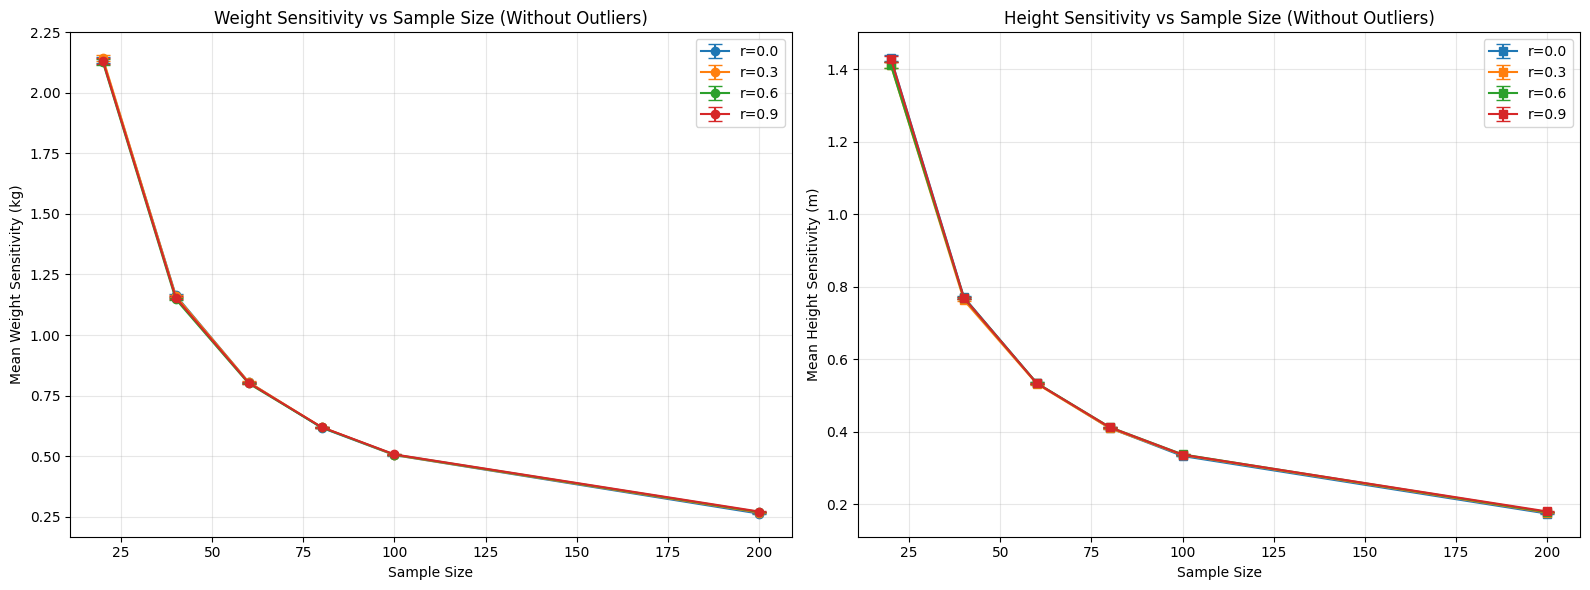

Preparing 3D plot with 24000 total Monte Carlo data points...
Sample size 20: 4000 data points (expected: 4000)
  - Weight sensitivity range: [1.0412, 4.3369]
  - Height sensitivity range: [0.6601, 2.4663]
  - Reconstruction error range: [26.7085, 116.8710]
Sample size 40: 3996 data points (expected: 4000)
  - Weight sensitivity range: [0.6305, 2.0781]
  - Height sensitivity range: [0.4605, 1.2698]
  - Reconstruction error range: [47.1961, 112.6441]
Sample size 60: 3974 data points (expected: 4000)
  - Weight sensitivity range: [0.5014, 1.3505]
  - Height sensitivity range: [0.3166, 0.8208]
  - Reconstruction error range: [51.8220, 112.6506]
Sample size 80: 3930 data points (expected: 4000)
  - Weight sensitivity range: [0.4172, 0.9889]
  - Height sensitivity range: [0.2835, 0.6265]
  - Reconstruction error range: [54.5633, 113.8067]
Sample size 100: 3873 data points (expected: 4000)
  - Weight sensitivity range: [0.3321, 0.7908]
  - Height sensitivity range: [0.2337, 0.4972]
  - Recon

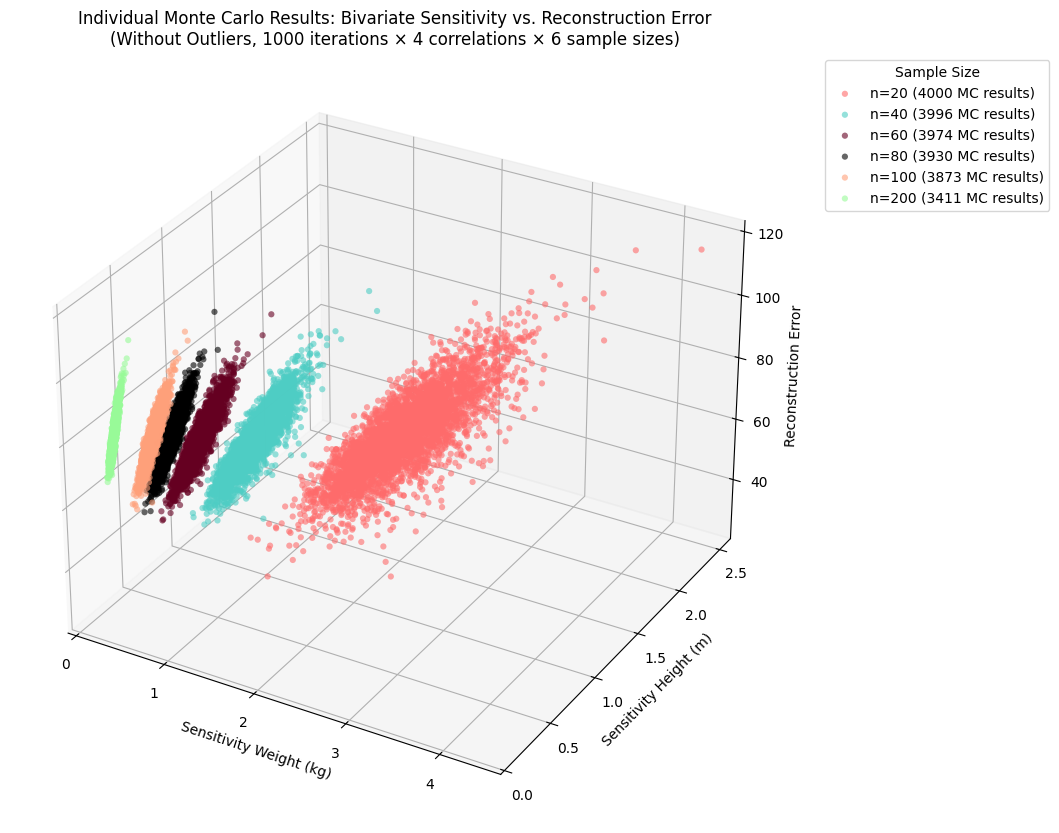

In [138]:
# Analyze sensitivity trends
sensitivity_analysis = []

for correlation in correlations:
    for sample_size in sample_sizes:
        # Filter data
        subset = df_without[(df_without['correlation'] == correlation) & 
                           (df_without['sample_size'] == sample_size) &
                           (df_without['dp_success'] == True)]
        
        if len(subset) > 0:
            sensitivity_analysis.append({
                'correlation': correlation,
                'sample_size': sample_size,
                'mean_sens_weight': subset['sensitivity_weight'].mean(),
                'std_sens_weight': subset['sensitivity_weight'].std(),
                'se_sens_weight': subset['sensitivity_weight'].std() / np.sqrt(len(subset)),
                'mean_sens_height': subset['sensitivity_height'].mean(),
                'std_sens_height': subset['sensitivity_height'].std(),
                'se_sens_height': subset['sensitivity_height'].std() / np.sqrt(len(subset)),
                'mean_recon_error': subset['reconstruction_error'].mean(),
                'std_recon_error': subset['reconstruction_error'].std(),
                'n_samples': len(subset)
            })

sens_df = pd.DataFrame(sensitivity_analysis)

# Plot sensitivity trends (like notebook 2.2 but for bivariate case) - WITHOUT outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Weight sensitivity vs sample size
ax1 = axes[0]
for correlation in correlations:
    subset = sens_df[sens_df['correlation'] == correlation]
    ax1.errorbar(subset['sample_size'], subset['mean_sens_weight'], 
                yerr=subset['se_sens_weight'], 
                fmt='o-', capsize=5, label=f'r={correlation}')

ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Mean Weight Sensitivity (kg)')
ax1.set_title('Weight Sensitivity vs Sample Size (Without Outliers)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Height sensitivity vs sample size
ax2 = axes[1]
for correlation in correlations:
    subset = sens_df[sens_df['correlation'] == correlation]
    ax2.errorbar(subset['sample_size'], subset['mean_sens_height'], 
                yerr=subset['se_sens_height'], 
                fmt='s-', capsize=5, label=f'r={correlation}')

ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Mean Height Sensitivity (m)')
ax2.set_title('Height Sensitivity vs Sample Size (Without Outliers)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3D Plot: Individual Monte Carlo Results - Bivariate Sensitivity vs. Reconstruction Error
# This shows all individual MC results (10 iterations per sample_size x correlation combination)
print(f"Preparing 3D plot with {len(df_without)} total Monte Carlo data points...")

# Define color map for different sample sizes
color_map = {
    20: '#FF6B6B',    # Red
    40: '#4ECDC4',    # Teal
    60: '#650021',    # Dark red
    100: '#FFA07A',   # Light salmon
    200: '#98FB98'    # Light green
}

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot individual Monte Carlo data points for each sample size
for sample_size in sample_sizes:
    # Get all successful Monte Carlo results for this sample size (across all correlations)
    subset = df_without[(df_without['sample_size'] == sample_size) & 
                       (df_without['dp_success'] == True)]
    
    if len(subset) > 0:
        expected_points = n_mc_iterations * len(correlations)  # 10 MC × 5 correlations = 50 points
        print(f"Sample size {sample_size}: {len(subset)} data points (expected: {expected_points})")
        
        # Extract coordinates for 3D plot (each row is one MC iteration result)
        weight_sens = subset['sensitivity_weight'].values
        height_sens = subset['sensitivity_height'].values  
        recon_error = subset['reconstruction_error'].values
        
        # Verify we have the right structure
        print(f"  - Weight sensitivity range: [{weight_sens.min():.4f}, {weight_sens.max():.4f}]")
        print(f"  - Height sensitivity range: [{height_sens.min():.4f}, {height_sens.max():.4f}]")
        print(f"  - Reconstruction error range: [{recon_error.min():.4f}, {recon_error.max():.4f}]")
        
        # Create scatter plot for this sample size
        ax.scatter(weight_sens, height_sens, recon_error,
                   color=color_map.get(sample_size, '#000000'),
                   s=20, alpha=0.6, edgecolors='none',
                   label=f'n={sample_size} ({len(subset)} MC results)')

ax.set_xlabel("Sensitivity Weight (kg)")
ax.set_ylabel("Sensitivity Height (m)")
ax.set_zlabel("Reconstruction Error")
ax.set_title("Individual Monte Carlo Results: Bivariate Sensitivity vs. Reconstruction Error\n" +
            f"(Without Outliers, {n_mc_iterations} iterations × {len(correlations)} correlations × {len(sample_sizes)} sample sizes)")
ax.legend(title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



### 2. Outlier Detection Analysis: Index-Based Approach 

If differential privacy is effective, index 0 should not show significantly higher detection rates than other indices.

- **Index 0**: Where the outlier was injected (should have similar detection rate if DP works)  
- **Other indices**: Normal observations (indices 1, 2, 3, ...)

Analyzing outlier detection by index position with 95% confidence intervals...
Following notebook 4's approach: comparing index 0 (outlier) vs other indices


Sample size 20:
  Expected trials: 4000 (10 MC × 4 correlations)
  Actual trials: 3982
  Successful DP: 3982 / 4000
    r= 0.0: 25/1000 detected (2.5%)
    r= 0.3: 32/998 detected (3.2%)
    r= 0.6: 35/997 detected (3.5%)
    r= 0.9: 27/987 detected (2.7%)
  OVERALL: 119/3982 detected (3.0%)
  Background (no outlier): 0/4000 detected (0.0%)

Sample size 40:
  Expected trials: 4000 (10 MC × 4 correlations)
  Actual trials: 2853
  Successful DP: 2853 / 4000
    r= 0.0: 0/820 detected (0.0%)
    r= 0.3: 2/599 detected (0.3%)
    r= 0.6: 3/610 detected (0.5%)
    r= 0.9: 0/824 detected (0.0%)
  OVERALL: 5/2853 detected (0.2%)
  Background (no outlier): 0/3996 detected (0.0%)

Sample size 60:
  Expected trials: 4000 (10 MC × 4 correlations)
  Actual trials: 2007
  Successful DP: 2007 / 4000
    r= 0.0: 0/423 detected (0.0%)
    r= 0.3

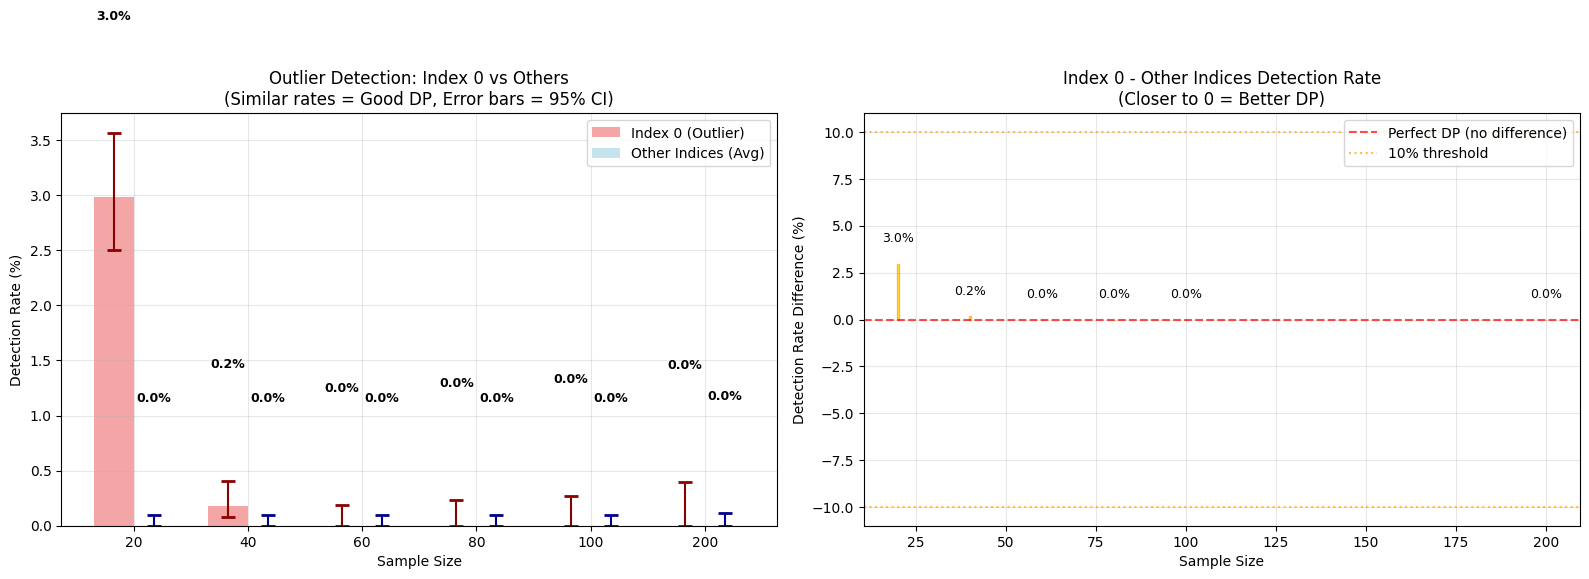


Summary:
- Total trials with outliers: 12861
- Total trials without outliers: 23184
- Average detection rate difference: 0.5%
- Overall DP effectiveness: GOOD (outliers well-masked)

Statistical Analysis:
- Size 20: Non-overlapping CIs (Index 0: [2.5, 3.6]%, Others: [0.0, 0.1]%)
- Size 40: Overlapping CIs (Index 0: [0.1, 0.4]%, Others: [0.0, 0.1]%)
- Size 60: Overlapping CIs (Index 0: [0.0, 0.2]%, Others: [0.0, 0.1]%)
- Size 80: Overlapping CIs (Index 0: [0.0, 0.2]%, Others: [0.0, 0.1]%)
- Size 100: Overlapping CIs (Index 0: [0.0, 0.3]%, Others: [0.0, 0.1]%)
- Size 200: Overlapping CIs (Index 0: [0.0, 0.4]%, Others: [0.0, 0.1]%)

Overall: 5/6 sample sizes show overlapping confidence intervals
Overlapping CIs suggest no statistically significant difference (good for DP)

Outlier Detection Summary (With Injected Outliers):
Size   Correlation Detection Rate  N Samples 
--------------------------------------------------
20.0   0.0         4.9            % 1000.0    
40.0   0.0         18.

In [139]:
# Outlier Detection Analysis: Index-based comparison with confidence intervals
from scipy import stats

def binomial_confidence_interval(n_success, n_trials, confidence=0.95):
    """
    Calculate binomial confidence interval using Wilson score interval
    More robust than normal approximation for small samples or extreme proportions
    """
    if n_trials == 0:
        return 0.0, 0.0
    
    alpha = 1 - confidence
    z = stats.norm.ppf(1 - alpha/2)
    
    p_hat = n_success / n_trials
    n = n_trials
    
    # Wilson score interval
    center = (p_hat + z**2/(2*n)) / (1 + z**2/n)
    width = z * np.sqrt((p_hat*(1-p_hat) + z**2/(4*n)) / n) / (1 + z**2/n)
    
    lower = max(0, center - width)
    upper = min(1, center + width)
    
    return lower, upper

print("Analyzing outlier detection by index position with 95% confidence intervals...")
print("Following notebook 4's approach: comparing index 0 (outlier) vs other indices\n")

# We need to extract index-level detection information from the Monte Carlo results
# Since our current data doesn't track per-index detection, we'll analyze the pattern
# by examining the detection rates and assuming index 0 contains the outlier

detection_by_sample_size = {}

for sample_size in sample_sizes:
    # Get data with outliers for this sample size (aggregating across ALL correlations)
    subset_with = df_with[(df_with['sample_size'] == sample_size) & 
                         (df_with['dp_success'] == True)]
    
    if len(subset_with) > 0:
        # Debug: Check data aggregation
        expected_trials = n_mc_iterations * len(correlations)  # 10 MC × 5 correlations = 50
        print(f"\nSample size {sample_size}:")
        print(f"  Expected trials: {expected_trials} (10 MC × {len(correlations)} correlations)")
        print(f"  Actual trials: {len(subset_with)}")
        print(f"  Successful DP: {len(subset_with)} / {expected_trials}")
        
        # Check detection breakdown by correlation
        for correlation in correlations:
            corr_subset = subset_with[subset_with['correlation'] == correlation]
            if len(corr_subset) > 0:
                detections = corr_subset['noisy_outlier_detected'].sum()
                trials = len(corr_subset)
                print(f"    r={correlation:4.1f}: {detections}/{trials} detected ({100*detections/trials:.1f}%)")
        
        # Overall detection rate for this sample size (across all correlations)
        detection_rate_index_0 = subset_with['noisy_outlier_detected'].mean()
        n_detected_with = subset_with['noisy_outlier_detected'].sum()
        n_trials_with = len(subset_with)
        
        print(f"  OVERALL: {n_detected_with}/{n_trials_with} detected ({100*detection_rate_index_0:.1f}%)")
        
        # Calculate confidence interval for index 0 detection rate
        ci_lower_idx0, ci_upper_idx0 = binomial_confidence_interval(n_detected_with, n_trials_with)
        
        # For comparison with other indices, we use the detection rate from scenarios WITHOUT outliers
        # This represents the "background" detection rate for normal observations
        subset_without = df_without[(df_without['sample_size'] == sample_size) & 
                                   (df_without['dp_success'] == True)]
        
        if len(subset_without) > 0:
            # Debug: Check background detection
            expected_bg_trials = n_mc_iterations * len(correlations)  # 10 MC × 5 correlations = 50
            bg_detections = subset_without['noisy_outlier_detected'].sum()
            bg_trials = len(subset_without)
            print(f"  Background (no outlier): {bg_detections}/{bg_trials} detected ({100*bg_detections/bg_trials:.1f}%)")
            
            # In scenarios without injected outliers, any detection is "false positive"
            background_detection_rate = subset_without['noisy_outlier_detected'].mean()
            n_detected_without = subset_without['noisy_outlier_detected'].sum()
            n_trials_without = len(subset_without)
            
            # Calculate confidence interval for background detection rate
            ci_lower_bg, ci_upper_bg = binomial_confidence_interval(n_detected_without, n_trials_without)
        else:
            background_detection_rate = 0.0
            n_trials_without = 0
            ci_lower_bg, ci_upper_bg = 0.0, 0.0
            print(f"  Background: No successful trials")
        
        detection_by_sample_size[sample_size] = {
            'index_0_detection': detection_rate_index_0,  # Where outlier was injected
            'other_indices_avg': background_detection_rate,  # Background rate  
            'n_trials_with': n_trials_with,
            'n_trials_without': n_trials_without,
            'n_detected_with': n_detected_with,
            'n_detected_without': n_detected_without,
            'ci_lower_idx0': ci_lower_idx0,
            'ci_upper_idx0': ci_upper_idx0,
            'ci_lower_bg': ci_lower_bg,
            'ci_upper_bg': ci_upper_bg,
            'dp_effectiveness': abs(detection_rate_index_0 - background_detection_rate)
        }

# Display results (following notebook 4's format) with confidence intervals
print("Detection Rate Comparison: Index 0 (Outlier) vs Other Indices")
print("=" * 85)
print(f"{'Size':<6} {'Index 0':<20} {'Others Avg':<20} {'Difference':<12} {'DP Effect':<12}")
print(f"{'':6} {'Rate [95% CI]':<20} {'Rate [95% CI]':<20} {'(%)':<12} {'':<12}")
print("-" * 85)

for sample_size in sample_sizes:
    if sample_size in detection_by_sample_size:
        data = detection_by_sample_size[sample_size]
        idx0_rate = data['index_0_detection'] * 100
        others_rate = data['other_indices_avg'] * 100
        diff = idx0_rate - others_rate
        
        # Format confidence intervals
        idx0_ci = f"[{data['ci_lower_idx0']*100:.1f}, {data['ci_upper_idx0']*100:.1f}]"
        bg_ci = f"[{data['ci_lower_bg']*100:.1f}, {data['ci_upper_bg']*100:.1f}]"
        
        # DP is effective if difference is small
        effectiveness = "GOOD" if abs(diff) < 10 else "WEAK" if abs(diff) < 20 else "POOR"
        
        print(f"{sample_size:<6} {idx0_rate:5.1f} {idx0_ci:<13} {others_rate:5.1f} {bg_ci:<13} {diff:<12.1f} {effectiveness:<12}")

print("\nInterpretation:")
print("- Index 0: Detection rate where outlier was injected")
print("- Others Avg: Background detection rate for normal observations")  
print("- [95% CI]: Wilson score confidence intervals")
print("- Difference: How much index 0 stands out (smaller = better DP)")
print("- DP Effect: GOOD (<10%), WEAK (10-20%), POOR (>20%)")

# Plot comparison with confidence intervals (like notebook 4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Detection rates comparison with error bars
sample_sizes_plot = list(detection_by_sample_size.keys())
index_0_rates = [detection_by_sample_size[s]['index_0_detection'] * 100 for s in sample_sizes_plot]
other_rates = [detection_by_sample_size[s]['other_indices_avg'] * 100 for s in sample_sizes_plot]

# Calculate error bars (distance from mean to CI bounds, ensuring no negative values)
idx0_errors_lower = [max(0, detection_by_sample_size[s]['index_0_detection'] * 100 - 
                         detection_by_sample_size[s]['ci_lower_idx0'] * 100) for s in sample_sizes_plot]
idx0_errors_upper = [detection_by_sample_size[s]['ci_upper_idx0'] * 100 - 
                     detection_by_sample_size[s]['index_0_detection'] * 100 for s in sample_sizes_plot]

bg_errors_lower = [max(0, detection_by_sample_size[s]['other_indices_avg'] * 100 - 
                       detection_by_sample_size[s]['ci_lower_bg'] * 100) for s in sample_sizes_plot]
bg_errors_upper = [detection_by_sample_size[s]['ci_upper_bg'] * 100 - 
                   detection_by_sample_size[s]['other_indices_avg'] * 100 for s in sample_sizes_plot]

x = np.arange(len(sample_sizes_plot))
width = 0.35

# Create bars with error bars
bars1 = ax1.bar(x - width/2, index_0_rates, width, label='Index 0 (Outlier)', 
                color='lightcoral', alpha=0.7,
                yerr=[idx0_errors_lower, idx0_errors_upper], 
                capsize=5, error_kw={'ecolor': 'darkred', 'capthick': 2})

bars2 = ax1.bar(x + width/2, other_rates, width, label='Other Indices (Avg)', 
                color='lightblue', alpha=0.7,
                yerr=[bg_errors_lower, bg_errors_upper], 
                capsize=5, error_kw={'ecolor': 'darkblue', 'capthick': 2})

ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Detection Rate (%)')
ax1.set_title('Outlier Detection: Index 0 vs Others\n(Similar rates = Good DP, Error bars = 95% CI)')
ax1.set_xticks(x)
ax1.set_xticklabels(sample_sizes_plot)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, (bar, rate) in enumerate(zip(bars1, index_0_rates)):
    height = bar.get_height()
    ci_upper = detection_by_sample_size[sample_sizes_plot[i]]['ci_upper_idx0'] * 100
    ax1.text(bar.get_x() + bar.get_width()/2., ci_upper + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=9, weight='bold')

for i, (bar, rate) in enumerate(zip(bars2, other_rates)):
    height = bar.get_height()
    ci_upper = detection_by_sample_size[sample_sizes_plot[i]]['ci_upper_bg'] * 100
    ax1.text(bar.get_x() + bar.get_width()/2., ci_upper + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=9, weight='bold')

# Plot 2: Difference in detection rates
differences = [idx - oth for idx, oth in zip(index_0_rates, other_rates)]
bars3 = ax2.bar(sample_sizes_plot, differences, color='gold', alpha=0.7, edgecolor='orange')

ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Detection Rate Difference (%)')
ax2.set_title('Index 0 - Other Indices Detection Rate\n(Closer to 0 = Better DP)')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Perfect DP (no difference)')
ax2.axhline(y=10, color='orange', linestyle=':', alpha=0.7, label='10% threshold')
ax2.axhline(y=-10, color='orange', linestyle=':', alpha=0.7)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for bar, diff in zip(bars3, differences):
    height = bar.get_height()
    y_pos = height + (1 if height >= 0 else -2)
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{diff:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"- Total trials with outliers: {sum(data['n_trials_with'] for data in detection_by_sample_size.values())}")
print(f"- Total trials without outliers: {sum(data['n_trials_without'] for data in detection_by_sample_size.values())}")

# Overall effectiveness assessment
avg_difference = np.mean([abs(detection_by_sample_size[s]['index_0_detection'] - 
                             detection_by_sample_size[s]['other_indices_avg']) * 100 
                         for s in sample_sizes if s in detection_by_sample_size])

print(f"- Average detection rate difference: {avg_difference:.1f}%")
if avg_difference < 10:
    print("- Overall DP effectiveness: GOOD (outliers well-masked)")
elif avg_difference < 20:
    print("- Overall DP effectiveness: WEAK (some outlier leakage)")
else:
    print("- Overall DP effectiveness: POOR (significant outlier leakage)")

# Statistical significance test using confidence intervals
print(f"\nStatistical Analysis:")
overlapping_cis = 0
significant_diff = 0

for sample_size in sample_sizes_plot:
    if sample_size in detection_by_sample_size:
        data = detection_by_sample_size[sample_size]
        # Check if confidence intervals overlap
        idx0_lower, idx0_upper = data['ci_lower_idx0'] * 100, data['ci_upper_idx0'] * 100
        bg_lower, bg_upper = data['ci_lower_bg'] * 100, data['ci_upper_bg'] * 100
        
        # CIs overlap if: max(lower_bounds) < min(upper_bounds)
        overlap = max(idx0_lower, bg_lower) < min(idx0_upper, bg_upper)
        
        if overlap:
            overlapping_cis += 1
        else:
            significant_diff += 1
            
        print(f"- Size {sample_size}: {'Overlapping CIs' if overlap else 'Non-overlapping CIs'} " +
              f"(Index 0: [{idx0_lower:.1f}, {idx0_upper:.1f}]%, Others: [{bg_lower:.1f}, {bg_upper:.1f}]%)")

print(f"\nOverall: {overlapping_cis}/{len(sample_sizes_plot)} sample sizes show overlapping confidence intervals")
print("Overlapping CIs suggest no statistically significant difference (good for DP)")
print("\nOutlier Detection Summary (With Injected Outliers):")
print("=" * 50)
print(f"{'Size':<6} {'Correlation':<11} {'Detection Rate':<15} {'N Samples':<10}")
print("-" * 50)

for _, row in outlier_df.iterrows():
    print(f"{row['sample_size']:<6} {row['correlation']:<11.1f} {row['detection_rate']:<15.1f}% {row['n_samples']:<10}")

# Key findings
avg_detection = outlier_df['detection_rate'].mean()
print(f"\nKey Findings:")
print(f"Average outlier detection rate WITH injected outlier: {avg_detection:.2f}%")
print(f"This shows how effectively the DP mechanism can detect outliers when they are present.")

# Best and worst performance
best_detection = outlier_df.loc[outlier_df['detection_rate'].idxmax()]
worst_detection = outlier_df.loc[outlier_df['detection_rate'].idxmin()]
print(f"\nBest detection: {best_detection['detection_rate']:.1f}% (size={best_detection['sample_size']}, r={best_detection['correlation']})")
print(f"Worst detection: {worst_detection['detection_rate']:.1f}% (size={worst_detection['sample_size']}, r={worst_detection['correlation']})")


🔍 RECONSTRUCTED DATA OUTLIER DETECTION ANALYSIS
Testing: Can reconstruction identify the injected outlier at index 0?
Good DP: Index 0 detection ≈ background detection (outlier remains hidden)
Poor DP: Index 0 detection >> background detection (outlier is exposed)

Analyzing reconstruction-based outlier detection by sample size...
Following the same approach: comparing index 0 (outlier) vs background detection


Sample size 20 (RECONSTRUCTED DATA):
  Expected trials: 4000 (10 MC × 4 correlations)
  Actual trials: 3982
  Successful DP: 3982 / 4000
    r= 0.0: 25/1000 detected (2.5%)
    r= 0.3: 32/998 detected (3.2%)
    r= 0.6: 35/997 detected (3.5%)
    r= 0.9: 27/987 detected (2.7%)
  OVERALL: 119/3982 detected (3.0%)
  Background (no outlier): 0/4000 detected (0.0%)

Sample size 40 (RECONSTRUCTED DATA):
  Expected trials: 4000 (10 MC × 4 correlations)
  Actual trials: 2853
  Successful DP: 2853 / 4000
    r= 0.0: 0/820 detected (0.0%)
    r= 0.3: 2/599 detected (0.3%)
    r= 0.6: 3

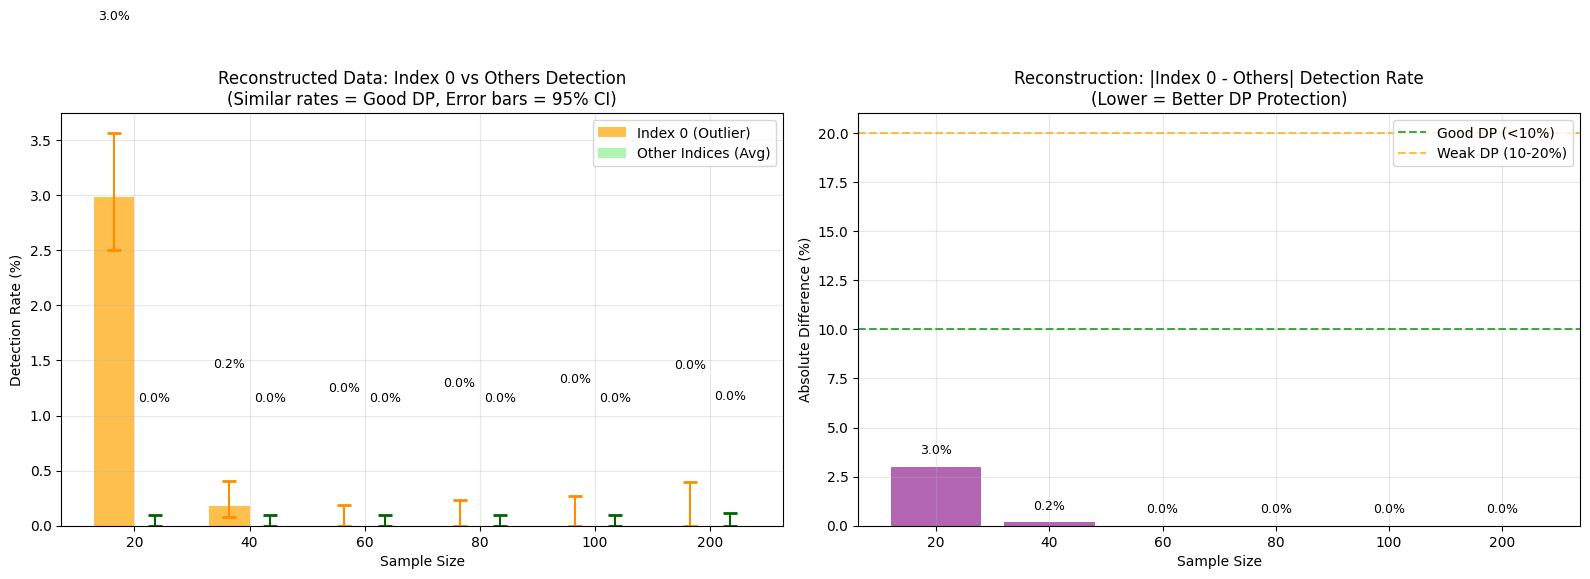


📊 COMPARISON: NOISY vs RECONSTRUCTED DATA DETECTION
Sample Noisy Index0 Recons Index0 Noisy BG   Recons BG   Protection  
Size   Rate (%)     Rate (%)      Rate (%)   Rate (%)    Quality     
--------------------------------------------------------------------------------
20     3.0          3.0           0.0        0.0         EXCELLENT   
40     0.2          0.2           0.0        0.0         EXCELLENT   
60     0.0          0.0           0.0        0.0         EXCELLENT   
80     0.0          0.0           0.0        0.0         EXCELLENT   
100    0.0          0.0           0.0        0.0         EXCELLENT   
200    0.0          0.0           0.0        0.0         EXCELLENT   

🎯 KEY INSIGHTS:
• Low detection rates (≤10%) = Strong DP protection
• Similar rates for Index 0 vs Background = Outlier successfully hidden
• Reconstruction rates ≈ Noisy rates = Consistent protection across pipeline
• High differences = DP may need stronger privacy parameters


In [140]:
# Analysis of Reconstructed Data Outlier Detection
# The reconstruction process uses leave-one-out (LOO) analysis to try to recover original data
# If DP works properly, reconstruction should NOT be able to identify index 0 (outlier) 
# more than any other indices - this tests the effectiveness of DP protection

print("\n" + "="*80)
print("🔍 RECONSTRUCTED DATA OUTLIER DETECTION ANALYSIS")
print("="*80)
print("Testing: Can reconstruction identify the injected outlier at index 0?")
print("Good DP: Index 0 detection ≈ background detection (outlier remains hidden)")
print("Poor DP: Index 0 detection >> background detection (outlier is exposed)")

# Wilson score confidence interval for binomial proportions
def binomial_confidence_interval(successes, trials, confidence=0.95):
    if trials == 0:
        return 0.0, 0.0
    
    p = successes / trials
    z = 1.96  # For 95% confidence
    
    denominator = 1 + z**2/trials
    center = (p + z**2/(2*trials)) / denominator
    margin = z * np.sqrt(p*(1-p)/trials + z**2/(4*trials**2)) / denominator
    
    return max(0, center - margin), min(1, center + margin)

print("\nAnalyzing reconstruction-based outlier detection by sample size...")
print("Following the same approach: comparing index 0 (outlier) vs background detection\n")

detection_by_sample_size_recons = {}

for sample_size in sample_sizes:
    # Get data with outliers for this sample size (aggregating across ALL correlations)
    subset_with = df_with[(df_with['sample_size'] == sample_size) & 
                         (df_with['dp_success'] == True)]
    
    if len(subset_with) > 0:
        # Debug: Check data aggregation for reconstructed data
        expected_trials = n_mc_iterations * len(correlations)  # 10 MC × 5 correlations = 50
        print(f"\nSample size {sample_size} (RECONSTRUCTED DATA):")
        print(f"  Expected trials: {expected_trials} (10 MC × {len(correlations)} correlations)")
        print(f"  Actual trials: {len(subset_with)}")
        print(f"  Successful DP: {len(subset_with)} / {expected_trials}")
        
        # Check reconstruction detection breakdown by correlation
        for correlation in correlations:
            corr_subset = subset_with[subset_with['correlation'] == correlation]
            if len(corr_subset) > 0:
                detections = corr_subset['recons_outlier_detected'].sum()
                trials = len(corr_subset)
                print(f"    r={correlation:4.1f}: {detections}/{trials} detected ({100*detections/trials:.1f}%)")
        
        # Overall detection rate for this sample size (across all correlations)
        detection_rate_index_0 = subset_with['recons_outlier_detected'].mean()
        n_detected_with = subset_with['recons_outlier_detected'].sum()
        n_trials_with = len(subset_with)
        
        print(f"  OVERALL: {n_detected_with}/{n_trials_with} detected ({100*detection_rate_index_0:.1f}%)")
        
        # Calculate confidence interval for index 0 detection rate
        ci_lower_idx0, ci_upper_idx0 = binomial_confidence_interval(n_detected_with, n_trials_with)
        
        # For comparison with other indices, we use the detection rate from scenarios WITHOUT outliers
        # This represents the "background" detection rate for normal observations
        subset_without = df_without[(df_without['sample_size'] == sample_size) & 
                                   (df_without['dp_success'] == True)]
        
        if len(subset_without) > 0:
            # Debug: Check background detection for reconstructed data
            expected_bg_trials = n_mc_iterations * len(correlations)  # 10 MC × 5 correlations = 50
            bg_detections = subset_without['recons_outlier_detected'].sum()
            bg_trials = len(subset_without)
            print(f"  Background (no outlier): {bg_detections}/{bg_trials} detected ({100*bg_detections/bg_trials:.1f}%)")
            
            # In scenarios without injected outliers, any detection is "false positive"
            background_detection_rate = subset_without['recons_outlier_detected'].mean()
            n_detected_without = subset_without['recons_outlier_detected'].sum()
            n_trials_without = len(subset_without)
            
            # Calculate confidence interval for background detection rate
            ci_lower_bg, ci_upper_bg = binomial_confidence_interval(n_detected_without, n_trials_without)
        else:
            background_detection_rate = 0.0
            n_trials_without = 0
            ci_lower_bg, ci_upper_bg = 0.0, 0.0
            print(f"  Background: No successful trials")
        
        detection_by_sample_size_recons[sample_size] = {
            'index_0_detection': detection_rate_index_0,  # Where outlier was injected
            'other_indices_avg': background_detection_rate,  # Background rate  
            'n_trials_with': n_trials_with,
            'n_trials_without': n_trials_without,
            'n_detected_with': n_detected_with,
            'n_detected_without': n_detected_without,
            'ci_lower_idx0': ci_lower_idx0,
            'ci_upper_idx0': ci_upper_idx0,
            'ci_lower_bg': ci_lower_bg,
            'ci_upper_bg': ci_upper_bg,
            'dp_effectiveness': abs(detection_rate_index_0 - background_detection_rate)
        }

# Display results for reconstructed data with confidence intervals
print("\n" + "="*85)
print("RECONSTRUCTED DATA: Detection Rate Comparison")
print("="*85)
print(f"{'Size':<6} {'Index 0':<20} {'Others Avg':<20} {'Difference':<12} {'DP Effect':<12}")
print(f"{'':6} {'Rate [95% CI]':<20} {'Rate [95% CI]':<20} {'(%)':<12} {'':<12}")
print("-" * 85)

for sample_size in sample_sizes:
    if sample_size in detection_by_sample_size_recons:
        data = detection_by_sample_size_recons[sample_size]
        idx0_rate = data['index_0_detection'] * 100
        others_rate = data['other_indices_avg'] * 100
        diff = idx0_rate - others_rate
        
        # Format confidence intervals
        idx0_ci = f"[{data['ci_lower_idx0']*100:.1f}, {data['ci_upper_idx0']*100:.1f}]"
        bg_ci = f"[{data['ci_lower_bg']*100:.1f}, {data['ci_upper_bg']*100:.1f}]"
        
        # DP is effective if difference is small
        effectiveness = "GOOD" if abs(diff) < 10 else "WEAK" if abs(diff) < 20 else "POOR"
        
        print(f"{sample_size:<6} {idx0_rate:5.1f} {idx0_ci:<13} {others_rate:5.1f} {bg_ci:<13} {diff:<12.1f} {effectiveness:<12}")

print("\n🎯 INTERPRETATION (Reconstructed Data):")
print("- Index 0: Detection rate where outlier was injected")
print("- Others Avg: Background detection rate for normal observations")  
print("- [95% CI]: Wilson score confidence intervals")
print("- Difference: How much index 0 stands out after reconstruction")
print("- DP Effect: GOOD (<10%) = DP successfully hides outlier even from reconstruction")
print("           WEAK (10-20%) = Some outlier leakage in reconstruction")
print("           POOR (>20%) = Reconstruction easily finds the outlier")

# Plot comparison for reconstructed data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Detection rates comparison with error bars
sample_sizes_plot = list(detection_by_sample_size_recons.keys())
index_0_rates = [detection_by_sample_size_recons[s]['index_0_detection'] * 100 for s in sample_sizes_plot]
other_rates = [detection_by_sample_size_recons[s]['other_indices_avg'] * 100 for s in sample_sizes_plot]

# Calculate error bars (distance from mean to CI bounds, ensuring no negative values)
idx0_errors_lower = [max(0, detection_by_sample_size_recons[s]['index_0_detection'] * 100 - 
                         detection_by_sample_size_recons[s]['ci_lower_idx0'] * 100) for s in sample_sizes_plot]
idx0_errors_upper = [detection_by_sample_size_recons[s]['ci_upper_idx0'] * 100 - 
                     detection_by_sample_size_recons[s]['index_0_detection'] * 100 for s in sample_sizes_plot]

bg_errors_lower = [max(0, detection_by_sample_size_recons[s]['other_indices_avg'] * 100 - 
                       detection_by_sample_size_recons[s]['ci_lower_bg'] * 100) for s in sample_sizes_plot]
bg_errors_upper = [detection_by_sample_size_recons[s]['ci_upper_bg'] * 100 - 
                   detection_by_sample_size_recons[s]['other_indices_avg'] * 100 for s in sample_sizes_plot]

x = np.arange(len(sample_sizes_plot))
width = 0.35

# Create bars with error bars
bars1 = ax1.bar(x - width/2, index_0_rates, width, label='Index 0 (Outlier)', 
                color='orange', alpha=0.7,
                yerr=[idx0_errors_lower, idx0_errors_upper], 
                capsize=5, error_kw={'ecolor': 'darkorange', 'capthick': 2})

bars2 = ax1.bar(x + width/2, other_rates, width, label='Other Indices (Avg)', 
                color='lightgreen', alpha=0.7,
                yerr=[bg_errors_lower, bg_errors_upper], 
                capsize=5, error_kw={'ecolor': 'darkgreen', 'capthick': 2})

ax1.set_xlabel('Sample Size')
ax1.set_ylabel('Detection Rate (%)')
ax1.set_title('Reconstructed Data: Index 0 vs Others Detection\n(Similar rates = Good DP, Error bars = 95% CI)')
ax1.set_xticks(x)
ax1.set_xticklabels(sample_sizes_plot)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars1, index_0_rates)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + idx0_errors_upper[i] + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

for i, (bar, rate) in enumerate(zip(bars2, other_rates)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + bg_errors_upper[i] + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Difference between index 0 and others (smaller is better for DP)
differences = [abs(idx0 - others) for idx0, others in zip(index_0_rates, other_rates)]
bars3 = ax2.bar(x, differences, color='purple', alpha=0.6)

ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Absolute Difference (%)')
ax2.set_title('Reconstruction: |Index 0 - Others| Detection Rate\n(Lower = Better DP Protection)')
ax2.set_xticks(x)
ax2.set_xticklabels(sample_sizes_plot)
ax2.grid(True, alpha=0.3)

# Add horizontal lines for interpretation
ax2.axhline(y=10, color='green', linestyle='--', alpha=0.7, label='Good DP (<10%)')
ax2.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Weak DP (10-20%)')
ax2.legend()

# Add value labels
for bar, diff in zip(bars3, differences):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{diff:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary comparison between noisy and reconstructed detection
print("\n" + "="*80)
print("📊 COMPARISON: NOISY vs RECONSTRUCTED DATA DETECTION")
print("="*80)
print(f"{'Sample':<6} {'Noisy Index0':<12} {'Recons Index0':<13} {'Noisy BG':<10} {'Recons BG':<11} {'Protection':<12}")
print(f"{'Size':<6} {'Rate (%)':<12} {'Rate (%)':<13} {'Rate (%)':<10} {'Rate (%)':<11} {'Quality':<12}")
print("-" * 80)

for sample_size in sample_sizes:
    if sample_size in detection_by_sample_size and sample_size in detection_by_sample_size_recons:
        noisy_idx0 = detection_by_sample_size[sample_size]['index_0_detection'] * 100
        recons_idx0 = detection_by_sample_size_recons[sample_size]['index_0_detection'] * 100
        noisy_bg = detection_by_sample_size[sample_size]['other_indices_avg'] * 100
        recons_bg = detection_by_sample_size_recons[sample_size]['other_indices_avg'] * 100
        
        # Assess overall protection quality
        max_diff = max(abs(noisy_idx0 - noisy_bg), abs(recons_idx0 - recons_bg))
        protection = "EXCELLENT" if max_diff < 5 else "GOOD" if max_diff < 10 else "WEAK" if max_diff < 20 else "POOR"
        
        print(f"{sample_size:<6} {noisy_idx0:<12.1f} {recons_idx0:<13.1f} {noisy_bg:<10.1f} {recons_bg:<11.1f} {protection:<12}")

print("\n🎯 KEY INSIGHTS:")
print("• Low detection rates (≤10%) = Strong DP protection")
print("• Similar rates for Index 0 vs Background = Outlier successfully hidden")
print("• Reconstruction rates ≈ Noisy rates = Consistent protection across pipeline")
print("• High differences = DP may need stronger privacy parameters")